In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_household_electricity_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_household_electricity_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (2075259, 8)
set_index: DF Shape (2075259, 7)
resample_Data: DF Shape (1442, 7)
dataframe shape (1442, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [4]:
#dataframe = dataframe[-1825:].copy()
dataframe.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

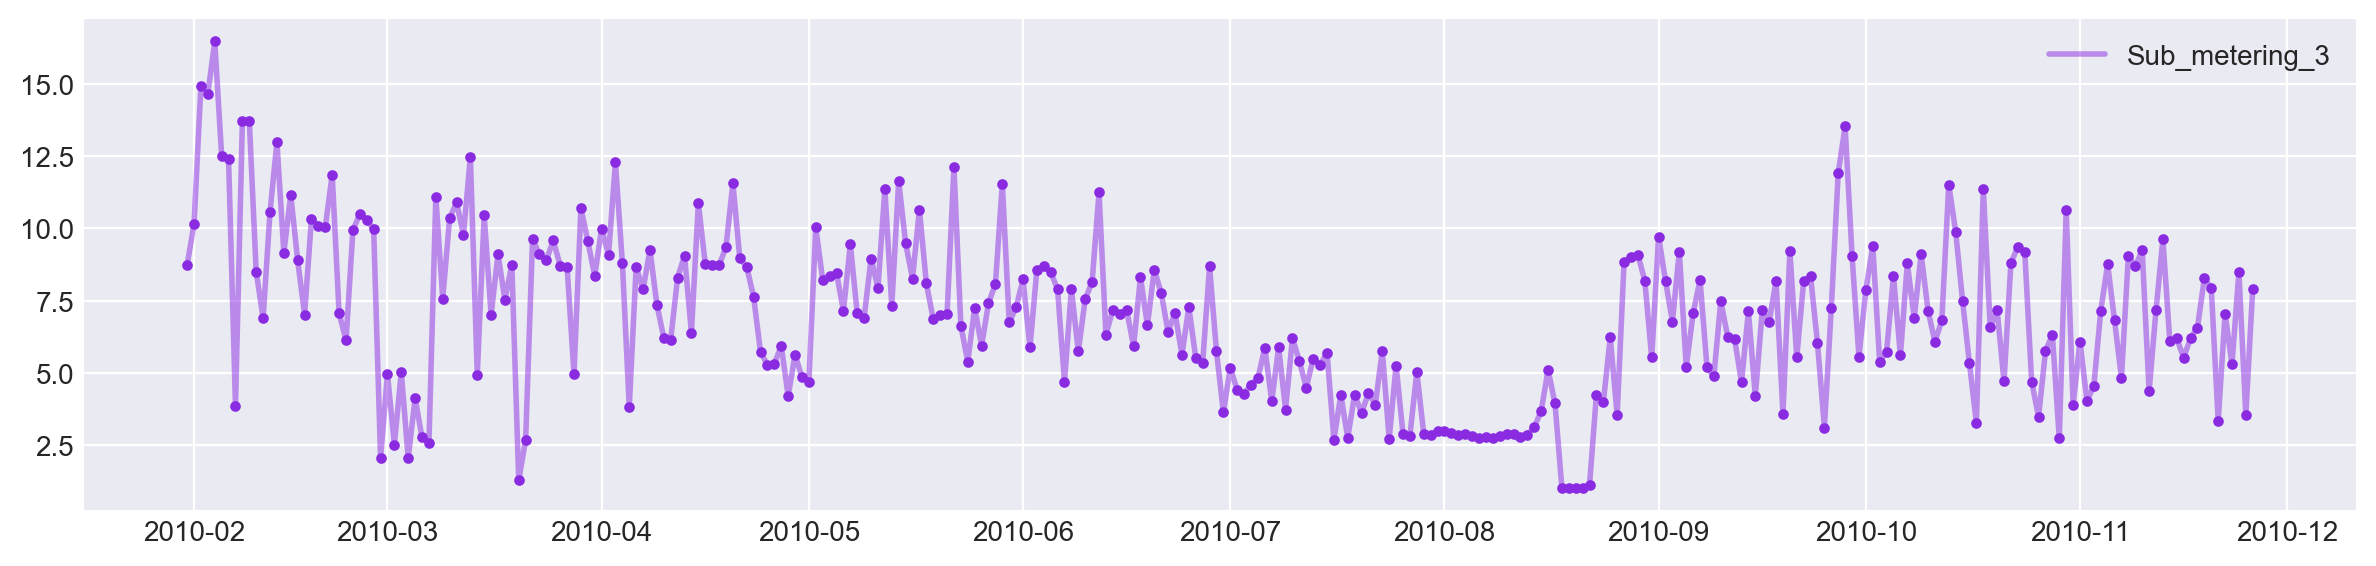

In [11]:
show_dataset(dataframe[-300:], columns=["Sub_metering_3"])

In [6]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "Sub_metering_3"
TEST_SIZE = 30

In [7]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1442, 7)
dataframe shape after Feature Union (1439, 26)

Train Size after Test_Train Split: (1409, 26)
Test  Size after Test_Train Split: (30, 26) 

train_x shape after seperate_target (1409, 25)
train_y shape after seperate_target (1409, 1)
test_x  shape after seperate_target (30, 25)
test_y  shape after seperate_target (30, 1)


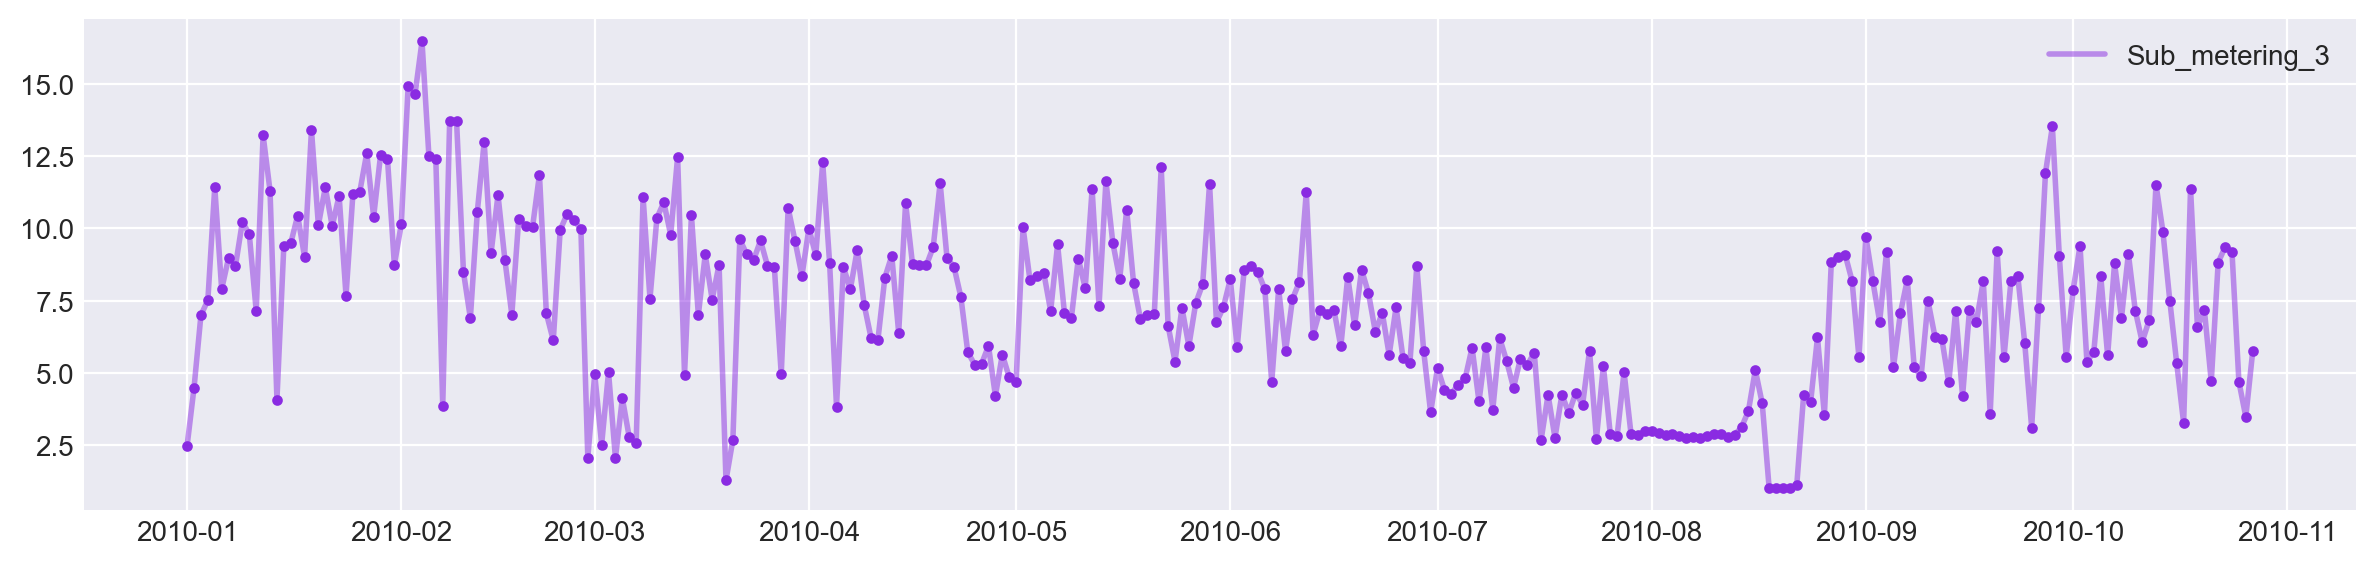

In [9]:
show_dataset(train_y[-300:], columns=["Sub_metering_3"])

In [13]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.139 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.173 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.256 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.232 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.203 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.343 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.290 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.270 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.361 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.277 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.274 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

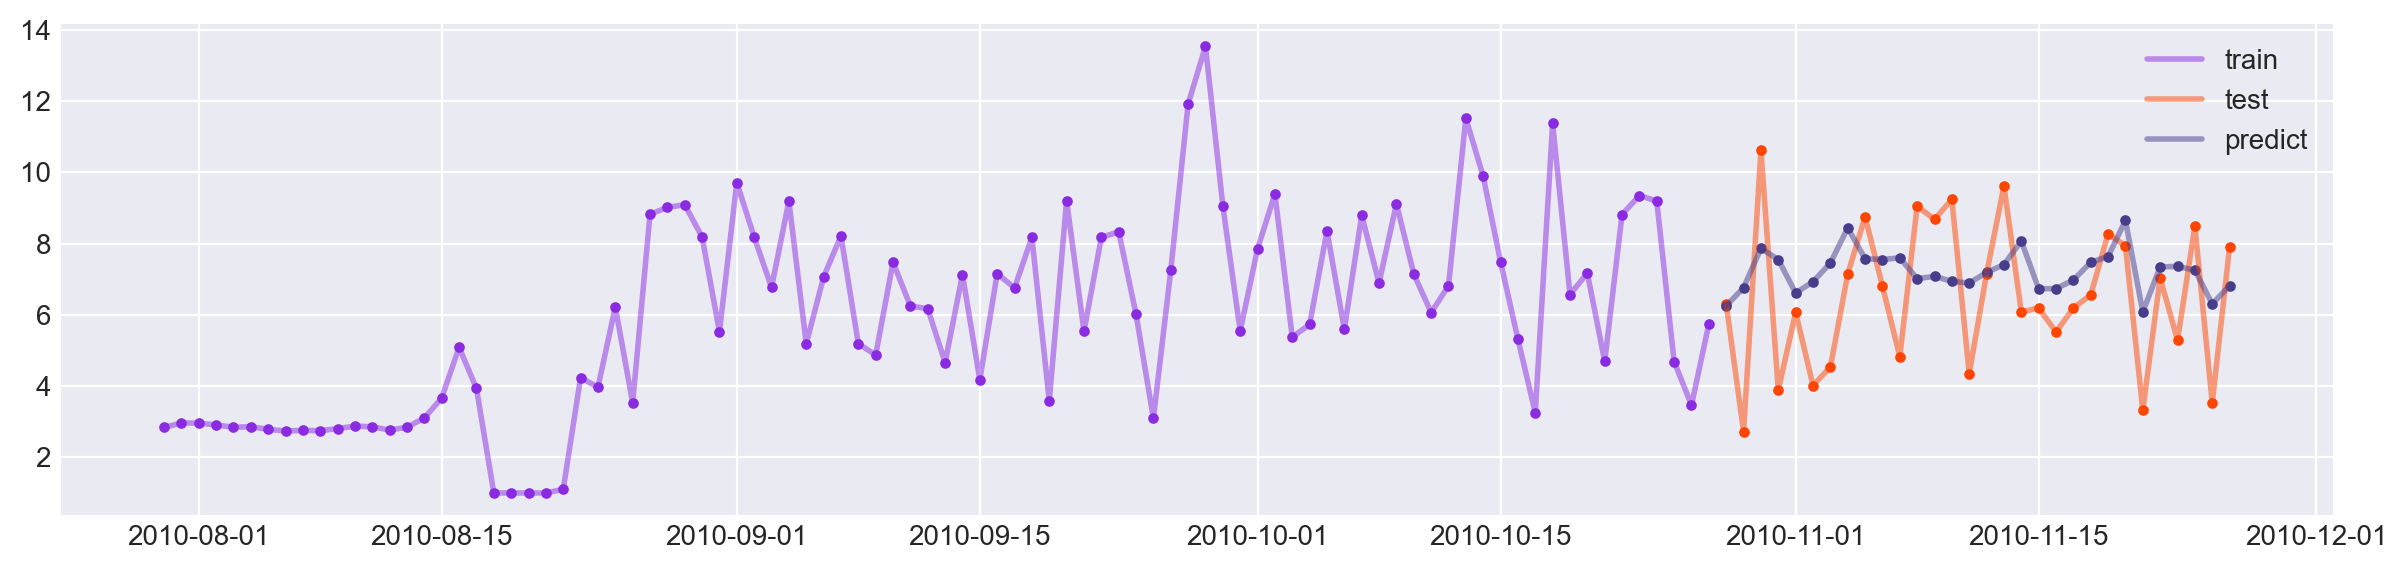

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [16]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  6  iterations


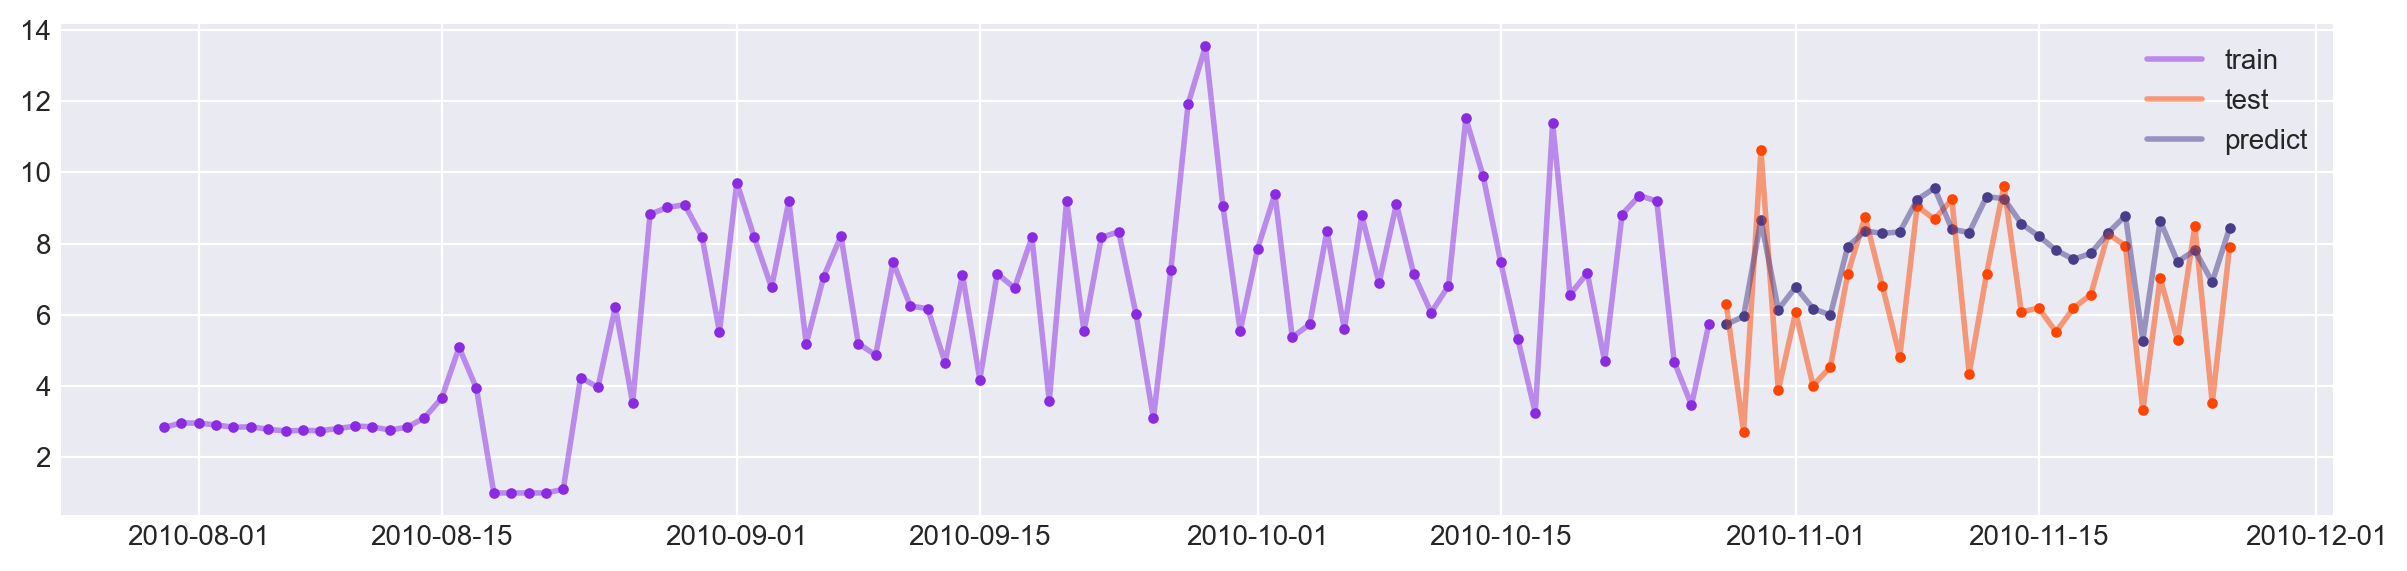

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [18]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LassoCV(max_iter=10000, fit_intercept=True)),
    ]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

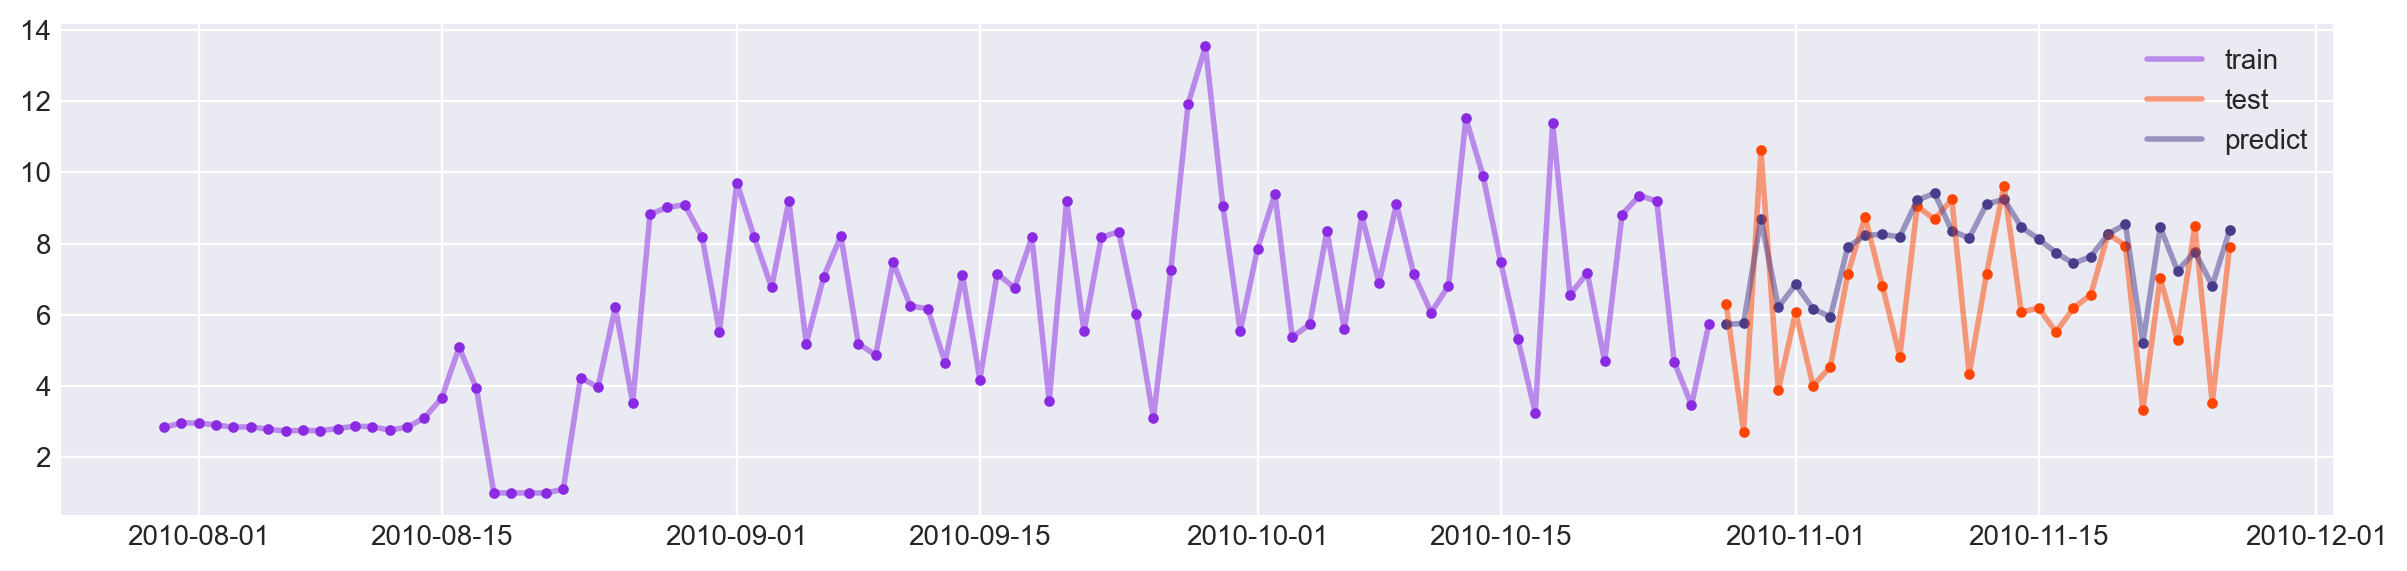

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# best Params {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [3],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.604 total time=   4.7s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.520 total time=   9.9s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.601 total time=  15.0s
0.574723301890008 {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}


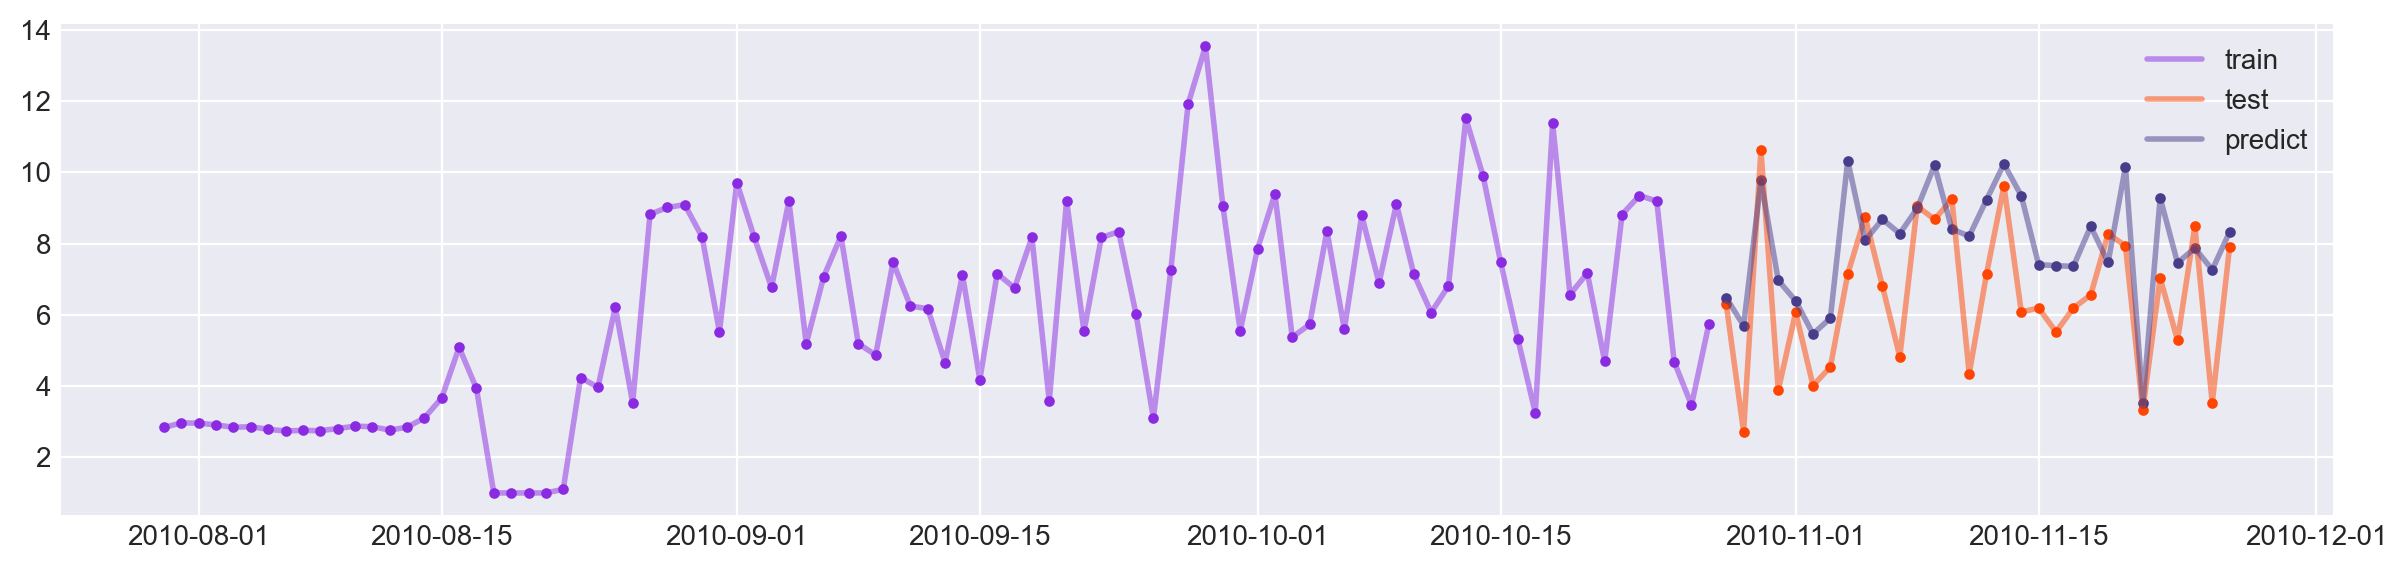

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:5.87786	validation_1-mae:5.96229
[1]	validation_0-mae:5.81991	validation_1-mae:5.88739
[2]	validation_0-mae:5.76252	validation_1-mae:5.81404
[3]	validation_0-mae:5.70572	validation_1-mae:5.74061
[4]	validation_0-mae:5.64952	validation_1-mae:5.66939
[5]	validation_0-mae:5.59383	validation_1-mae:5.59741
[6]	validation_0-mae:5.53872	validation_1-mae:5.52846
[7]	validation_0-mae:5.48421	validation_1-mae:5.45941
[8]	validation_0-mae:5.43015	validation_1-mae:5.39017
[9]	validation_0-mae:5.37662	validation_1-mae:5.32161
[10]	validation_0-mae:5.32375	validation_1-mae:5.25525
[11]	validation_0-mae:5.27126	validation_1-mae:5.18806
[12]	validation_0-mae:5.21937	validation_1-mae:5.12362
[13]	validation_0-mae:5.16811	validation_1-mae:5.05986
[14]	validation_0-mae:5.11727	validation_1-mae:4.99836
[15]	validation_0-mae:5.06700	validation_1-mae:4.93515
[16]	validation_0-mae:5.01712	validation_1-mae:4.87374
[17]	validation_0-mae:4.96764	validation_1-mae:4.81001
[18]	validation_0-ma

[149]	validation_0-mae:1.42937	validation_1-mae:1.21883
[150]	validation_0-mae:1.41785	validation_1-mae:1.21685
[151]	validation_0-mae:1.40642	validation_1-mae:1.21102
[152]	validation_0-mae:1.39505	validation_1-mae:1.20793
[153]	validation_0-mae:1.38402	validation_1-mae:1.20243
[154]	validation_0-mae:1.37321	validation_1-mae:1.20010
[155]	validation_0-mae:1.36249	validation_1-mae:1.19412
[156]	validation_0-mae:1.35185	validation_1-mae:1.19137
[157]	validation_0-mae:1.34136	validation_1-mae:1.19041
[158]	validation_0-mae:1.33116	validation_1-mae:1.19058
[159]	validation_0-mae:1.32104	validation_1-mae:1.18701
[160]	validation_0-mae:1.31118	validation_1-mae:1.18617
[161]	validation_0-mae:1.30130	validation_1-mae:1.18419
[162]	validation_0-mae:1.29154	validation_1-mae:1.18468
[163]	validation_0-mae:1.28187	validation_1-mae:1.18519
[164]	validation_0-mae:1.27228	validation_1-mae:1.18429
[165]	validation_0-mae:1.26287	validation_1-mae:1.18365
[166]	validation_0-mae:1.25359	validation_1-mae:

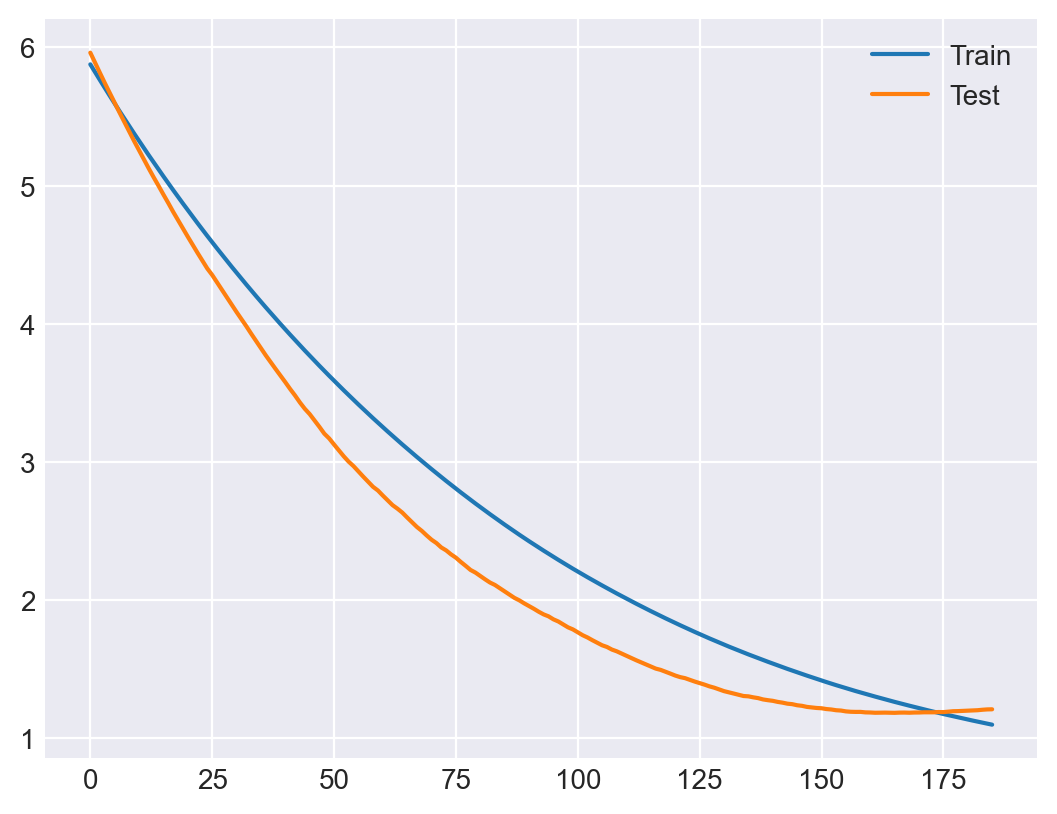

In [22]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

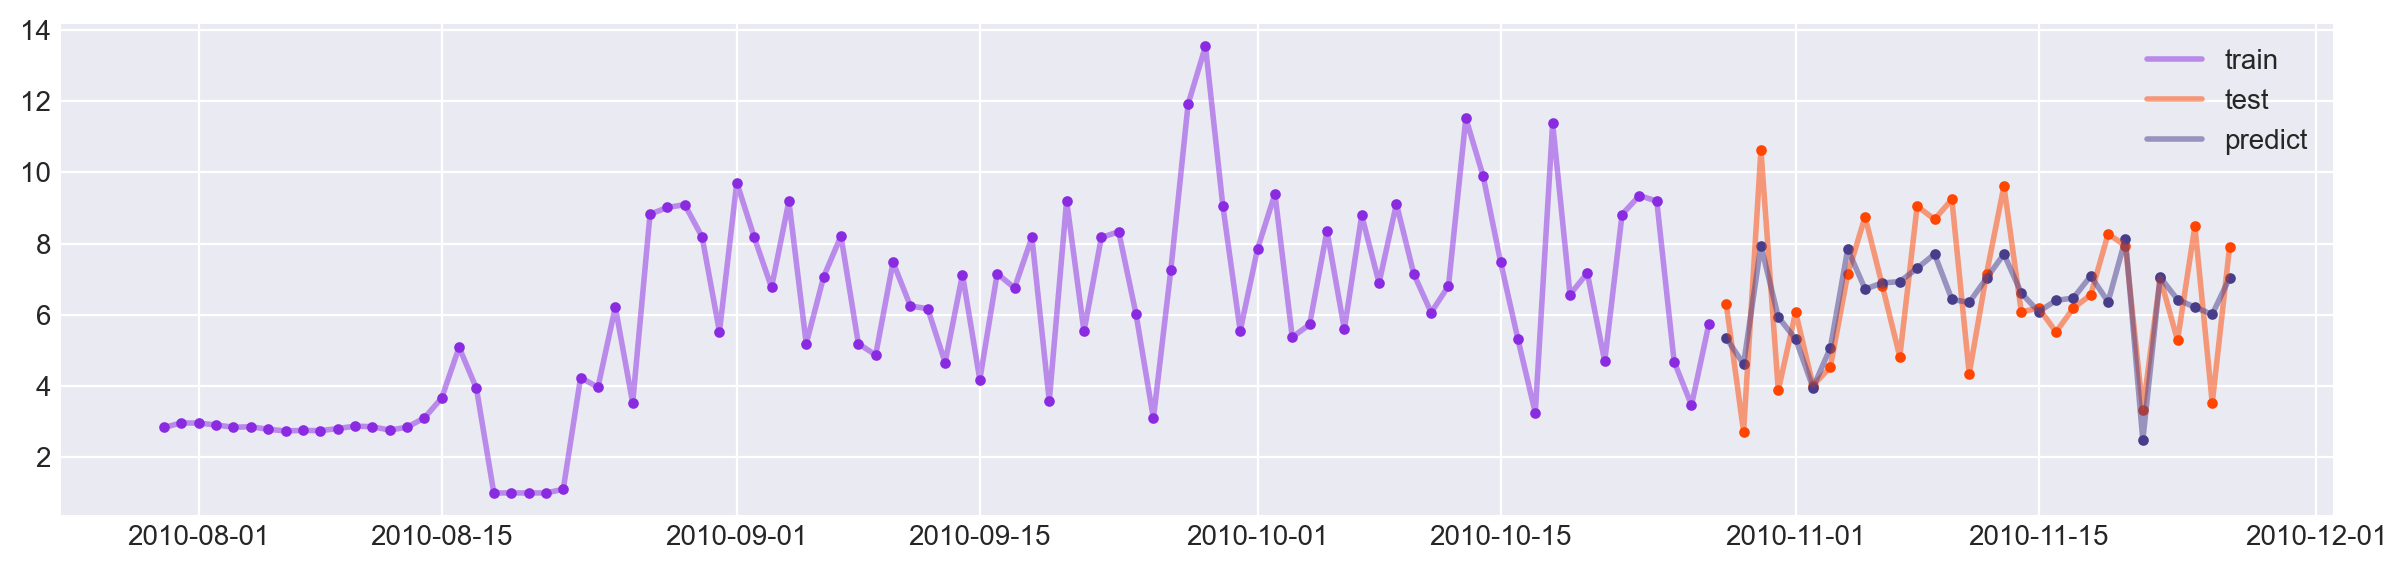

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [24]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 1.94316	training's l2: 5.95566	valid_1's l1: 1.58046	valid_1's l2: 3.69617
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 1.81271	training's l2: 5.1673	valid_1's l1: 1.49309	valid_1's l2: 3.3185
[3]	training's l1: 1.69497	training's l2: 4.50858	valid_1's l1: 1.47895	valid_1's l2: 3.18275
[4]	training's l1: 1.5886	training's l2: 3.96328	valid_1's l1: 1.4576	valid_1's l2: 3.03981
[5]	training's l1: 1.4931	training's l2: 3.50929	valid_1's l1: 1.46309	valid_1's l2: 2.98464
[6]	training's l1: 1.41177	training's l2: 3.13606	valid_1's l1: 1.49056	valid_1's l2: 3.02448
[7]	training's l1: 1.33823	training's l2: 2.82232	valid_1's l1: 1.49136	valid_1's l2: 3.01362
[8]	training's l1: 1.27292	training's l2: 2.56294	valid_1's l1: 1.50357	valid_1's l2: 3.06741
[9]	training's l1: 1.21406	training's l2: 2.3443	valid_1's l1: 1.51459	valid_1's l2: 3.11149
[10]	training's l1: 1.16282	training's l2: 2.15696	valid_1's l1: 1.53554	valid_1's l2: 3.20828
[1

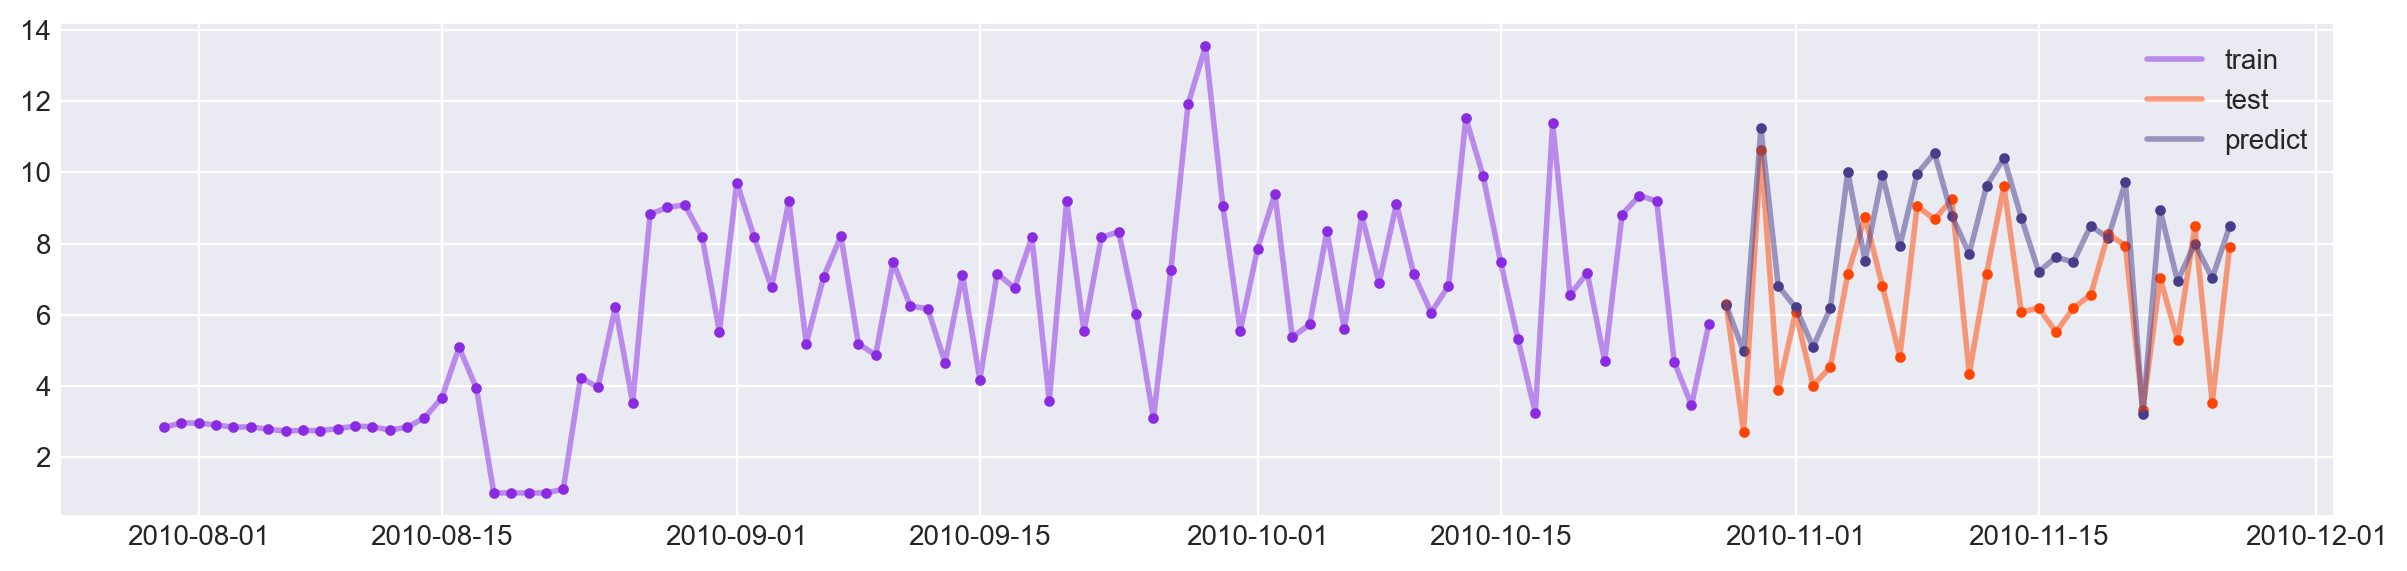

In [25]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [26]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 6.1756590	test: 7.1750030	best: 7.1750030 (0)	total: 140ms	remaining: 2m 19s
1:	learn: 5.6350978	test: 6.6437850	best: 6.6437850 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 5.1535004	test: 6.1579381	best: 6.1579381 (2)	total: 150ms	remaining: 49.8s
3:	learn: 4.7251203	test: 5.7303346	best: 5.7303346 (3)	total: 154ms	remaining: 38.4s
4:	learn: 4.3335885	test: 5.4894220	best: 5.4894220 (4)	total: 159ms	remaining: 31.5s
5:	learn: 3.9962148	test: 5.1818687	best: 5.1818687 (5)	total: 163ms	remaining: 27s
6:	learn: 3.6896906	test: 4.8810506	best: 4.8810506 (6)	total: 168ms	remaining: 23.8s
7:	learn: 3.4156915	test: 4.5995933	best: 4.5995933 (7)	total: 183ms	remaining: 22.7s
8:	learn: 3.1972693	test: 4.3752012	best: 4.3752012 (8)	total: 197ms	remaining: 21.7s
9:	learn: 2.9833615	test: 4.1489878	best: 4.1489878 (9)	total: 207ms	remaining: 20.5s
10:	learn: 2.7973532	test: 3.9453189	best: 3.9453189 (10)	total: 218ms	remaining: 19.6s
11:	learn: 2.6271501	test: 3.7617961	best: 3.7617961

102:	learn: 1.1323567	test: 1.7632859	best: 1.7632859 (102)	total: 1.66s	remaining: 14.4s
103:	learn: 1.1308513	test: 1.7633684	best: 1.7632859 (102)	total: 1.67s	remaining: 14.4s
104:	learn: 1.1294907	test: 1.7473060	best: 1.7473060 (104)	total: 1.69s	remaining: 14.4s
105:	learn: 1.1262744	test: 1.7458290	best: 1.7458290 (105)	total: 1.7s	remaining: 14.3s
106:	learn: 1.1218042	test: 1.7445686	best: 1.7445686 (106)	total: 1.71s	remaining: 14.3s
107:	learn: 1.1195842	test: 1.7445558	best: 1.7445558 (107)	total: 1.72s	remaining: 14.2s
108:	learn: 1.1167551	test: 1.7431675	best: 1.7431675 (108)	total: 1.73s	remaining: 14.2s
109:	learn: 1.1118036	test: 1.7393502	best: 1.7393502 (109)	total: 1.74s	remaining: 14.1s
110:	learn: 1.1077741	test: 1.7398694	best: 1.7393502 (109)	total: 1.74s	remaining: 14s
111:	learn: 1.1040117	test: 1.7429212	best: 1.7393502 (109)	total: 1.75s	remaining: 13.8s
112:	learn: 1.1019216	test: 1.7441450	best: 1.7393502 (109)	total: 1.76s	remaining: 13.8s
113:	learn: 1

205:	learn: 0.8971662	test: 1.7244671	best: 1.6996533 (156)	total: 3.15s	remaining: 12.2s
206:	learn: 0.8953148	test: 1.7238991	best: 1.6996533 (156)	total: 3.17s	remaining: 12.1s
207:	learn: 0.8948225	test: 1.7247521	best: 1.6996533 (156)	total: 3.18s	remaining: 12.1s
208:	learn: 0.8932564	test: 1.7242302	best: 1.6996533 (156)	total: 3.2s	remaining: 12.1s
209:	learn: 0.8910143	test: 1.7258357	best: 1.6996533 (156)	total: 3.21s	remaining: 12.1s
210:	learn: 0.8899417	test: 1.7252681	best: 1.6996533 (156)	total: 3.23s	remaining: 12.1s
211:	learn: 0.8887373	test: 1.7252530	best: 1.6996533 (156)	total: 3.24s	remaining: 12s
212:	learn: 0.8865117	test: 1.7251270	best: 1.6996533 (156)	total: 3.25s	remaining: 12s
213:	learn: 0.8850135	test: 1.7237981	best: 1.6996533 (156)	total: 3.27s	remaining: 12s
214:	learn: 0.8838377	test: 1.7242219	best: 1.6996533 (156)	total: 3.3s	remaining: 12.1s
215:	learn: 0.8810386	test: 1.7212334	best: 1.6996533 (156)	total: 3.33s	remaining: 12.1s
216:	learn: 0.8796

305:	learn: 0.7520071	test: 1.7454410	best: 1.6996533 (156)	total: 4.63s	remaining: 10.5s
306:	learn: 0.7511211	test: 1.7453891	best: 1.6996533 (156)	total: 4.63s	remaining: 10.5s
307:	learn: 0.7498295	test: 1.7450358	best: 1.6996533 (156)	total: 4.64s	remaining: 10.4s
308:	learn: 0.7478451	test: 1.7445663	best: 1.6996533 (156)	total: 4.64s	remaining: 10.4s
309:	learn: 0.7461281	test: 1.7433851	best: 1.6996533 (156)	total: 4.64s	remaining: 10.3s
310:	learn: 0.7442780	test: 1.7416132	best: 1.6996533 (156)	total: 4.65s	remaining: 10.3s
311:	learn: 0.7422394	test: 1.7448548	best: 1.6996533 (156)	total: 4.66s	remaining: 10.3s
312:	learn: 0.7415210	test: 1.7483472	best: 1.6996533 (156)	total: 4.69s	remaining: 10.3s
313:	learn: 0.7400249	test: 1.7479929	best: 1.6996533 (156)	total: 4.71s	remaining: 10.3s
314:	learn: 0.7383031	test: 1.7488000	best: 1.6996533 (156)	total: 4.76s	remaining: 10.3s
315:	learn: 0.7362729	test: 1.7488116	best: 1.6996533 (156)	total: 4.77s	remaining: 10.3s
316:	learn

405:	learn: 0.6349026	test: 1.7633219	best: 1.6996533 (156)	total: 6.33s	remaining: 9.27s
406:	learn: 0.6336557	test: 1.7631276	best: 1.6996533 (156)	total: 6.35s	remaining: 9.25s
407:	learn: 0.6322415	test: 1.7618220	best: 1.6996533 (156)	total: 6.36s	remaining: 9.23s
408:	learn: 0.6313314	test: 1.7599502	best: 1.6996533 (156)	total: 6.37s	remaining: 9.2s
409:	learn: 0.6294839	test: 1.7579633	best: 1.6996533 (156)	total: 6.38s	remaining: 9.18s
410:	learn: 0.6284523	test: 1.7575517	best: 1.6996533 (156)	total: 6.39s	remaining: 9.15s
411:	learn: 0.6277832	test: 1.7580547	best: 1.6996533 (156)	total: 6.41s	remaining: 9.14s
412:	learn: 0.6261490	test: 1.7583190	best: 1.6996533 (156)	total: 6.44s	remaining: 9.15s
413:	learn: 0.6254682	test: 1.7575499	best: 1.6996533 (156)	total: 6.47s	remaining: 9.16s
414:	learn: 0.6250032	test: 1.7572905	best: 1.6996533 (156)	total: 6.49s	remaining: 9.15s
415:	learn: 0.6239032	test: 1.7577609	best: 1.6996533 (156)	total: 6.5s	remaining: 9.13s
416:	learn: 

506:	learn: 0.5438066	test: 1.7660124	best: 1.6996533 (156)	total: 7.85s	remaining: 7.63s
507:	learn: 0.5424352	test: 1.7663050	best: 1.6996533 (156)	total: 7.85s	remaining: 7.6s
508:	learn: 0.5416423	test: 1.7664843	best: 1.6996533 (156)	total: 7.85s	remaining: 7.58s
509:	learn: 0.5406157	test: 1.7669602	best: 1.6996533 (156)	total: 7.86s	remaining: 7.55s
510:	learn: 0.5401852	test: 1.7668570	best: 1.6996533 (156)	total: 7.86s	remaining: 7.52s
511:	learn: 0.5395190	test: 1.7676988	best: 1.6996533 (156)	total: 7.87s	remaining: 7.5s
512:	learn: 0.5388678	test: 1.7679821	best: 1.6996533 (156)	total: 7.88s	remaining: 7.48s
513:	learn: 0.5378359	test: 1.7681293	best: 1.6996533 (156)	total: 7.89s	remaining: 7.46s
514:	learn: 0.5368854	test: 1.7672454	best: 1.6996533 (156)	total: 7.92s	remaining: 7.46s
515:	learn: 0.5359837	test: 1.7674195	best: 1.6996533 (156)	total: 7.94s	remaining: 7.45s
516:	learn: 0.5350660	test: 1.7669040	best: 1.6996533 (156)	total: 7.96s	remaining: 7.43s
517:	learn: 

603:	learn: 0.4776599	test: 1.7856889	best: 1.6996533 (156)	total: 9.31s	remaining: 6.11s
604:	learn: 0.4774389	test: 1.7852917	best: 1.6996533 (156)	total: 9.32s	remaining: 6.08s
605:	learn: 0.4770135	test: 1.7848787	best: 1.6996533 (156)	total: 9.32s	remaining: 6.06s
606:	learn: 0.4762936	test: 1.7851040	best: 1.6996533 (156)	total: 9.32s	remaining: 6.04s
607:	learn: 0.4746295	test: 1.7844467	best: 1.6996533 (156)	total: 9.32s	remaining: 6.01s
608:	learn: 0.4739556	test: 1.7843832	best: 1.6996533 (156)	total: 9.33s	remaining: 5.99s
609:	learn: 0.4730519	test: 1.7836503	best: 1.6996533 (156)	total: 9.33s	remaining: 5.97s
610:	learn: 0.4722598	test: 1.7846413	best: 1.6996533 (156)	total: 9.36s	remaining: 5.96s
611:	learn: 0.4715025	test: 1.7845992	best: 1.6996533 (156)	total: 9.39s	remaining: 5.95s
612:	learn: 0.4710872	test: 1.7845424	best: 1.6996533 (156)	total: 9.42s	remaining: 5.95s
613:	learn: 0.4704934	test: 1.7848030	best: 1.6996533 (156)	total: 9.43s	remaining: 5.93s
614:	learn

701:	learn: 0.4135498	test: 1.7935866	best: 1.6996533 (156)	total: 10.6s	remaining: 4.51s
702:	learn: 0.4132200	test: 1.7935352	best: 1.6996533 (156)	total: 10.7s	remaining: 4.5s
703:	learn: 0.4123454	test: 1.7937753	best: 1.6996533 (156)	total: 10.7s	remaining: 4.48s
704:	learn: 0.4116122	test: 1.7934624	best: 1.6996533 (156)	total: 10.7s	remaining: 4.47s
705:	learn: 0.4111898	test: 1.7924378	best: 1.6996533 (156)	total: 10.7s	remaining: 4.45s
706:	learn: 0.4105117	test: 1.7920707	best: 1.6996533 (156)	total: 10.7s	remaining: 4.44s
707:	learn: 0.4099206	test: 1.7921149	best: 1.6996533 (156)	total: 10.7s	remaining: 4.42s
708:	learn: 0.4093577	test: 1.7923440	best: 1.6996533 (156)	total: 10.7s	remaining: 4.4s
709:	learn: 0.4086153	test: 1.7922115	best: 1.6996533 (156)	total: 10.8s	remaining: 4.39s
710:	learn: 0.4079898	test: 1.7923616	best: 1.6996533 (156)	total: 10.8s	remaining: 4.38s
711:	learn: 0.4074552	test: 1.7926215	best: 1.6996533 (156)	total: 10.8s	remaining: 4.37s
712:	learn: 

795:	learn: 0.3645923	test: 1.8002435	best: 1.6996533 (156)	total: 11.9s	remaining: 3.05s
796:	learn: 0.3641625	test: 1.8002224	best: 1.6996533 (156)	total: 11.9s	remaining: 3.04s
797:	learn: 0.3638562	test: 1.8004116	best: 1.6996533 (156)	total: 12s	remaining: 3.02s
798:	learn: 0.3634942	test: 1.8001076	best: 1.6996533 (156)	total: 12s	remaining: 3.01s
799:	learn: 0.3628580	test: 1.8001798	best: 1.6996533 (156)	total: 12s	remaining: 3s
800:	learn: 0.3623748	test: 1.8000152	best: 1.6996533 (156)	total: 12s	remaining: 2.98s
801:	learn: 0.3617931	test: 1.8002291	best: 1.6996533 (156)	total: 12s	remaining: 2.96s
802:	learn: 0.3611107	test: 1.8002473	best: 1.6996533 (156)	total: 12s	remaining: 2.95s
803:	learn: 0.3606046	test: 1.8002479	best: 1.6996533 (156)	total: 12s	remaining: 2.93s
804:	learn: 0.3603332	test: 1.8001730	best: 1.6996533 (156)	total: 12.1s	remaining: 2.92s
805:	learn: 0.3599748	test: 1.8000641	best: 1.6996533 (156)	total: 12.1s	remaining: 2.91s
806:	learn: 0.3594372	test:

896:	learn: 0.3215266	test: 1.8035352	best: 1.6996533 (156)	total: 13.4s	remaining: 1.54s
897:	learn: 0.3212573	test: 1.8034275	best: 1.6996533 (156)	total: 13.4s	remaining: 1.52s
898:	learn: 0.3207960	test: 1.8032942	best: 1.6996533 (156)	total: 13.4s	remaining: 1.5s
899:	learn: 0.3202896	test: 1.8030830	best: 1.6996533 (156)	total: 13.4s	remaining: 1.49s
900:	learn: 0.3199859	test: 1.8034297	best: 1.6996533 (156)	total: 13.4s	remaining: 1.47s
901:	learn: 0.3194348	test: 1.8032318	best: 1.6996533 (156)	total: 13.4s	remaining: 1.46s
902:	learn: 0.3191949	test: 1.8032441	best: 1.6996533 (156)	total: 13.4s	remaining: 1.44s
903:	learn: 0.3185015	test: 1.8035360	best: 1.6996533 (156)	total: 13.4s	remaining: 1.42s
904:	learn: 0.3180295	test: 1.8043873	best: 1.6996533 (156)	total: 13.4s	remaining: 1.41s
905:	learn: 0.3176533	test: 1.8046705	best: 1.6996533 (156)	total: 13.4s	remaining: 1.39s
906:	learn: 0.3174236	test: 1.8050957	best: 1.6996533 (156)	total: 13.4s	remaining: 1.38s
907:	learn:

999:	learn: 0.2846172	test: 1.8071631	best: 1.6996533 (156)	total: 14.9s	remaining: 0us

bestTest = 1.699653301
bestIteration = 156

0:	loss: 1.6996533	best: 1.6996533 (0)	total: 15.1s	remaining: 15.1s
0:	learn: 6.1916428	test: 7.1941361	best: 7.1941361 (0)	total: 17.9ms	remaining: 17.9s
1:	learn: 5.6592659	test: 6.6709669	best: 6.6709669 (1)	total: 31.9ms	remaining: 15.9s
2:	learn: 5.1837480	test: 6.1921571	best: 6.1921571 (2)	total: 48.1ms	remaining: 16s
3:	learn: 4.7615945	test: 5.7713350	best: 5.7713350 (3)	total: 60.8ms	remaining: 15.1s
4:	learn: 4.3696479	test: 5.5488191	best: 5.5488191 (4)	total: 72.8ms	remaining: 14.5s
5:	learn: 4.0344414	test: 5.2238662	best: 5.2238662 (5)	total: 82.8ms	remaining: 13.7s
6:	learn: 3.7249148	test: 4.9120648	best: 4.9120648 (6)	total: 92.7ms	remaining: 13.1s
7:	learn: 3.4513834	test: 4.6316195	best: 4.6316195 (7)	total: 97ms	remaining: 12s
8:	learn: 3.2328360	test: 4.4077470	best: 4.4077470 (8)	total: 100ms	remaining: 11s
9:	learn: 3.0207620	test

100:	learn: 1.1617521	test: 1.7643679	best: 1.7611159 (99)	total: 1.51s	remaining: 13.4s
101:	learn: 1.1579129	test: 1.7636465	best: 1.7611159 (99)	total: 1.54s	remaining: 13.6s
102:	learn: 1.1559603	test: 1.7650815	best: 1.7611159 (99)	total: 1.56s	remaining: 13.6s
103:	learn: 1.1522738	test: 1.7647005	best: 1.7611159 (99)	total: 1.57s	remaining: 13.6s
104:	learn: 1.1497060	test: 1.7629752	best: 1.7611159 (99)	total: 1.59s	remaining: 13.5s
105:	learn: 1.1475660	test: 1.7494010	best: 1.7494010 (105)	total: 1.6s	remaining: 13.5s
106:	learn: 1.1461940	test: 1.7530785	best: 1.7494010 (105)	total: 1.63s	remaining: 13.6s
107:	learn: 1.1429311	test: 1.7515373	best: 1.7494010 (105)	total: 1.66s	remaining: 13.7s
108:	learn: 1.1402993	test: 1.7454295	best: 1.7454295 (108)	total: 1.68s	remaining: 13.8s
109:	learn: 1.1391770	test: 1.7483369	best: 1.7454295 (108)	total: 1.71s	remaining: 13.8s
110:	learn: 1.1368054	test: 1.7476983	best: 1.7454295 (108)	total: 1.73s	remaining: 13.8s
111:	learn: 1.13

222:	learn: 0.8982178	test: 1.6681615	best: 1.6617606 (211)	total: 2.95s	remaining: 10.3s
223:	learn: 0.8961701	test: 1.6673461	best: 1.6617606 (211)	total: 2.95s	remaining: 10.2s
224:	learn: 0.8948928	test: 1.6698282	best: 1.6617606 (211)	total: 2.95s	remaining: 10.2s
225:	learn: 0.8925922	test: 1.6694643	best: 1.6617606 (211)	total: 2.95s	remaining: 10.1s
226:	learn: 0.8922405	test: 1.6698401	best: 1.6617606 (211)	total: 2.95s	remaining: 10.1s
227:	learn: 0.8901625	test: 1.6653352	best: 1.6617606 (211)	total: 2.96s	remaining: 10s
228:	learn: 0.8887846	test: 1.6642677	best: 1.6617606 (211)	total: 2.96s	remaining: 9.96s
229:	learn: 0.8871009	test: 1.6676774	best: 1.6617606 (211)	total: 2.96s	remaining: 9.93s
230:	learn: 0.8862330	test: 1.6688547	best: 1.6617606 (211)	total: 2.97s	remaining: 9.89s
231:	learn: 0.8834937	test: 1.6676041	best: 1.6617606 (211)	total: 2.98s	remaining: 9.85s
232:	learn: 0.8815933	test: 1.6689379	best: 1.6617606 (211)	total: 2.98s	remaining: 9.82s
233:	learn: 

342:	learn: 0.7462839	test: 1.6927722	best: 1.6617606 (211)	total: 3.56s	remaining: 6.81s
343:	learn: 0.7460274	test: 1.6930183	best: 1.6617606 (211)	total: 3.56s	remaining: 6.79s
344:	learn: 0.7454121	test: 1.6934675	best: 1.6617606 (211)	total: 3.56s	remaining: 6.76s
345:	learn: 0.7451733	test: 1.6937140	best: 1.6617606 (211)	total: 3.56s	remaining: 6.73s
346:	learn: 0.7449264	test: 1.6938011	best: 1.6617606 (211)	total: 3.56s	remaining: 6.7s
347:	learn: 0.7433344	test: 1.6946486	best: 1.6617606 (211)	total: 3.56s	remaining: 6.67s
348:	learn: 0.7422180	test: 1.6941834	best: 1.6617606 (211)	total: 3.56s	remaining: 6.64s
349:	learn: 0.7414879	test: 1.6936155	best: 1.6617606 (211)	total: 3.56s	remaining: 6.62s
350:	learn: 0.7390480	test: 1.6934031	best: 1.6617606 (211)	total: 3.56s	remaining: 6.59s
351:	learn: 0.7375374	test: 1.6937838	best: 1.6617606 (211)	total: 3.56s	remaining: 6.56s
352:	learn: 0.7362515	test: 1.6930382	best: 1.6617606 (211)	total: 3.57s	remaining: 6.54s
353:	learn:

460:	learn: 0.6361254	test: 1.7163623	best: 1.6617606 (211)	total: 4.19s	remaining: 4.9s
461:	learn: 0.6351326	test: 1.7159541	best: 1.6617606 (211)	total: 4.19s	remaining: 4.88s
462:	learn: 0.6336439	test: 1.7150795	best: 1.6617606 (211)	total: 4.19s	remaining: 4.86s
463:	learn: 0.6328497	test: 1.7142366	best: 1.6617606 (211)	total: 4.19s	remaining: 4.84s
464:	learn: 0.6313373	test: 1.7121372	best: 1.6617606 (211)	total: 4.19s	remaining: 4.83s
465:	learn: 0.6310345	test: 1.7129898	best: 1.6617606 (211)	total: 4.19s	remaining: 4.81s
466:	learn: 0.6304610	test: 1.7145409	best: 1.6617606 (211)	total: 4.2s	remaining: 4.79s
467:	learn: 0.6294775	test: 1.7151957	best: 1.6617606 (211)	total: 4.2s	remaining: 4.77s
468:	learn: 0.6284656	test: 1.7151004	best: 1.6617606 (211)	total: 4.2s	remaining: 4.75s
469:	learn: 0.6277851	test: 1.7151767	best: 1.6617606 (211)	total: 4.2s	remaining: 4.73s
470:	learn: 0.6275717	test: 1.7145741	best: 1.6617606 (211)	total: 4.2s	remaining: 4.72s
471:	learn: 0.62

573:	learn: 0.5476953	test: 1.7379677	best: 1.6617606 (211)	total: 4.61s	remaining: 3.42s
574:	learn: 0.5469864	test: 1.7369501	best: 1.6617606 (211)	total: 4.61s	remaining: 3.4s
575:	learn: 0.5463517	test: 1.7371915	best: 1.6617606 (211)	total: 4.61s	remaining: 3.39s
576:	learn: 0.5459764	test: 1.7370713	best: 1.6617606 (211)	total: 4.61s	remaining: 3.38s
577:	learn: 0.5451222	test: 1.7382419	best: 1.6617606 (211)	total: 4.61s	remaining: 3.37s
578:	learn: 0.5450840	test: 1.7382174	best: 1.6617606 (211)	total: 4.61s	remaining: 3.35s
579:	learn: 0.5442894	test: 1.7387635	best: 1.6617606 (211)	total: 4.61s	remaining: 3.34s
580:	learn: 0.5435628	test: 1.7392763	best: 1.6617606 (211)	total: 4.61s	remaining: 3.33s
581:	learn: 0.5430375	test: 1.7391810	best: 1.6617606 (211)	total: 4.62s	remaining: 3.31s
582:	learn: 0.5426487	test: 1.7411683	best: 1.6617606 (211)	total: 4.62s	remaining: 3.3s
583:	learn: 0.5424493	test: 1.7419128	best: 1.6617606 (211)	total: 4.62s	remaining: 3.29s
584:	learn: 

667:	learn: 0.4888753	test: 1.7474880	best: 1.6617606 (211)	total: 5.92s	remaining: 2.94s
668:	learn: 0.4881828	test: 1.7482356	best: 1.6617606 (211)	total: 5.93s	remaining: 2.93s
669:	learn: 0.4877659	test: 1.7479113	best: 1.6617606 (211)	total: 5.94s	remaining: 2.92s
670:	learn: 0.4865153	test: 1.7467992	best: 1.6617606 (211)	total: 5.95s	remaining: 2.92s
671:	learn: 0.4858276	test: 1.7473066	best: 1.6617606 (211)	total: 5.97s	remaining: 2.91s
672:	learn: 0.4853466	test: 1.7475246	best: 1.6617606 (211)	total: 5.98s	remaining: 2.91s
673:	learn: 0.4845354	test: 1.7476739	best: 1.6617606 (211)	total: 5.99s	remaining: 2.9s
674:	learn: 0.4837074	test: 1.7471935	best: 1.6617606 (211)	total: 6.01s	remaining: 2.89s
675:	learn: 0.4828724	test: 1.7484556	best: 1.6617606 (211)	total: 6.04s	remaining: 2.89s
676:	learn: 0.4824134	test: 1.7482606	best: 1.6617606 (211)	total: 6.07s	remaining: 2.9s
677:	learn: 0.4822318	test: 1.7482663	best: 1.6617606 (211)	total: 6.09s	remaining: 2.89s
678:	learn: 

768:	learn: 0.4327523	test: 1.7514744	best: 1.6617606 (211)	total: 7.43s	remaining: 2.23s
769:	learn: 0.4324550	test: 1.7522712	best: 1.6617606 (211)	total: 7.46s	remaining: 2.23s
770:	learn: 0.4317036	test: 1.7525870	best: 1.6617606 (211)	total: 7.47s	remaining: 2.22s
771:	learn: 0.4316003	test: 1.7525736	best: 1.6617606 (211)	total: 7.48s	remaining: 2.21s
772:	learn: 0.4312307	test: 1.7528485	best: 1.6617606 (211)	total: 7.49s	remaining: 2.2s
773:	learn: 0.4309597	test: 1.7528444	best: 1.6617606 (211)	total: 7.5s	remaining: 2.19s
774:	learn: 0.4305848	test: 1.7529327	best: 1.6617606 (211)	total: 7.51s	remaining: 2.18s
775:	learn: 0.4298384	test: 1.7529975	best: 1.6617606 (211)	total: 7.54s	remaining: 2.17s
776:	learn: 0.4295731	test: 1.7527872	best: 1.6617606 (211)	total: 7.56s	remaining: 2.17s
777:	learn: 0.4289240	test: 1.7526391	best: 1.6617606 (211)	total: 7.59s	remaining: 2.17s
778:	learn: 0.4285871	test: 1.7526516	best: 1.6617606 (211)	total: 7.61s	remaining: 2.16s
779:	learn: 

870:	learn: 0.3818725	test: 1.7585339	best: 1.6617606 (211)	total: 9.13s	remaining: 1.35s
871:	learn: 0.3814521	test: 1.7584931	best: 1.6617606 (211)	total: 9.16s	remaining: 1.34s
872:	learn: 0.3807358	test: 1.7585178	best: 1.6617606 (211)	total: 9.18s	remaining: 1.33s
873:	learn: 0.3804739	test: 1.7585327	best: 1.6617606 (211)	total: 9.2s	remaining: 1.33s
874:	learn: 0.3801500	test: 1.7583672	best: 1.6617606 (211)	total: 9.21s	remaining: 1.32s
875:	learn: 0.3798804	test: 1.7586873	best: 1.6617606 (211)	total: 9.23s	remaining: 1.31s
876:	learn: 0.3791825	test: 1.7585366	best: 1.6617606 (211)	total: 9.24s	remaining: 1.29s
877:	learn: 0.3787953	test: 1.7581247	best: 1.6617606 (211)	total: 9.25s	remaining: 1.28s
878:	learn: 0.3781342	test: 1.7579268	best: 1.6617606 (211)	total: 9.26s	remaining: 1.27s
879:	learn: 0.3780061	test: 1.7581279	best: 1.6617606 (211)	total: 9.26s	remaining: 1.26s
880:	learn: 0.3779116	test: 1.7586267	best: 1.6617606 (211)	total: 9.29s	remaining: 1.25s
881:	learn:

968:	learn: 0.3428899	test: 1.7605249	best: 1.6617606 (211)	total: 10.7s	remaining: 342ms
969:	learn: 0.3426382	test: 1.7603229	best: 1.6617606 (211)	total: 10.7s	remaining: 332ms
970:	learn: 0.3424192	test: 1.7607593	best: 1.6617606 (211)	total: 10.7s	remaining: 321ms
971:	learn: 0.3421234	test: 1.7606337	best: 1.6617606 (211)	total: 10.8s	remaining: 310ms
972:	learn: 0.3416232	test: 1.7614179	best: 1.6617606 (211)	total: 10.8s	remaining: 299ms
973:	learn: 0.3414731	test: 1.7614576	best: 1.6617606 (211)	total: 10.8s	remaining: 288ms
974:	learn: 0.3405269	test: 1.7614014	best: 1.6617606 (211)	total: 10.8s	remaining: 277ms
975:	learn: 0.3401066	test: 1.7615946	best: 1.6617606 (211)	total: 10.8s	remaining: 266ms
976:	learn: 0.3399215	test: 1.7617004	best: 1.6617606 (211)	total: 10.8s	remaining: 255ms
977:	learn: 0.3396797	test: 1.7615499	best: 1.6617606 (211)	total: 10.9s	remaining: 244ms
978:	learn: 0.3388432	test: 1.7619969	best: 1.6617606 (211)	total: 10.9s	remaining: 233ms
979:	learn

67:	learn: 1.2243514	test: 1.6521776	best: 1.6511659 (64)	total: 778ms	remaining: 10.7s
68:	learn: 1.2216362	test: 1.6526872	best: 1.6511659 (64)	total: 798ms	remaining: 10.8s
69:	learn: 1.2184061	test: 1.6530069	best: 1.6511659 (64)	total: 808ms	remaining: 10.7s
70:	learn: 1.2139313	test: 1.6513948	best: 1.6511659 (64)	total: 819ms	remaining: 10.7s
71:	learn: 1.2097959	test: 1.6505572	best: 1.6505572 (71)	total: 827ms	remaining: 10.7s
72:	learn: 1.2075782	test: 1.6490592	best: 1.6490592 (72)	total: 835ms	remaining: 10.6s
73:	learn: 1.2031958	test: 1.6471627	best: 1.6471627 (73)	total: 843ms	remaining: 10.5s
74:	learn: 1.2002341	test: 1.6450380	best: 1.6450380 (74)	total: 851ms	remaining: 10.5s
75:	learn: 1.1981982	test: 1.6449351	best: 1.6449351 (75)	total: 868ms	remaining: 10.6s
76:	learn: 1.1934824	test: 1.6436185	best: 1.6436185 (76)	total: 886ms	remaining: 10.6s
77:	learn: 1.1911693	test: 1.6424784	best: 1.6424784 (77)	total: 900ms	remaining: 10.6s
78:	learn: 1.1857748	test: 1.644

175:	learn: 0.9167765	test: 1.5740695	best: 1.5740695 (175)	total: 2.08s	remaining: 9.74s
176:	learn: 0.9130609	test: 1.5750568	best: 1.5740695 (175)	total: 2.1s	remaining: 9.74s
177:	learn: 0.9109643	test: 1.5755009	best: 1.5740695 (175)	total: 2.11s	remaining: 9.75s
178:	learn: 0.9078239	test: 1.5766212	best: 1.5740695 (175)	total: 2.12s	remaining: 9.74s
179:	learn: 0.9074223	test: 1.5769006	best: 1.5740695 (175)	total: 2.14s	remaining: 9.74s
180:	learn: 0.9051964	test: 1.5772040	best: 1.5740695 (175)	total: 2.15s	remaining: 9.72s
181:	learn: 0.9043533	test: 1.5773838	best: 1.5740695 (175)	total: 2.19s	remaining: 9.82s
182:	learn: 0.9018047	test: 1.5780646	best: 1.5740695 (175)	total: 2.2s	remaining: 9.81s
183:	learn: 0.8994340	test: 1.5784432	best: 1.5740695 (175)	total: 2.2s	remaining: 9.77s
184:	learn: 0.8979391	test: 1.5786166	best: 1.5740695 (175)	total: 2.21s	remaining: 9.74s
185:	learn: 0.8974785	test: 1.5783325	best: 1.5740695 (175)	total: 2.22s	remaining: 9.71s
186:	learn: 0

270:	learn: 0.7643326	test: 1.5735875	best: 1.5697586 (261)	total: 3.14s	remaining: 8.45s
271:	learn: 0.7624357	test: 1.5739483	best: 1.5697586 (261)	total: 3.16s	remaining: 8.46s
272:	learn: 0.7621889	test: 1.5742002	best: 1.5697586 (261)	total: 3.18s	remaining: 8.48s
273:	learn: 0.7618576	test: 1.5744226	best: 1.5697586 (261)	total: 3.2s	remaining: 8.49s
274:	learn: 0.7602182	test: 1.5738934	best: 1.5697586 (261)	total: 3.22s	remaining: 8.5s
275:	learn: 0.7582641	test: 1.5729720	best: 1.5697586 (261)	total: 3.24s	remaining: 8.5s
276:	learn: 0.7552897	test: 1.5704495	best: 1.5697586 (261)	total: 3.25s	remaining: 8.49s
277:	learn: 0.7547439	test: 1.5707336	best: 1.5697586 (261)	total: 3.27s	remaining: 8.48s
278:	learn: 0.7541802	test: 1.5714954	best: 1.5697586 (261)	total: 3.27s	remaining: 8.46s
279:	learn: 0.7530781	test: 1.5730424	best: 1.5697586 (261)	total: 3.29s	remaining: 8.45s
280:	learn: 0.7514004	test: 1.5757155	best: 1.5697586 (261)	total: 3.3s	remaining: 8.44s
281:	learn: 0.

364:	learn: 0.6482204	test: 1.5715540	best: 1.5657711 (319)	total: 4.18s	remaining: 7.28s
365:	learn: 0.6473175	test: 1.5718979	best: 1.5657711 (319)	total: 4.21s	remaining: 7.29s
366:	learn: 0.6461176	test: 1.5728665	best: 1.5657711 (319)	total: 4.23s	remaining: 7.29s
367:	learn: 0.6452106	test: 1.5736449	best: 1.5657711 (319)	total: 4.24s	remaining: 7.29s
368:	learn: 0.6437825	test: 1.5729385	best: 1.5657711 (319)	total: 4.26s	remaining: 7.29s
369:	learn: 0.6424088	test: 1.5722904	best: 1.5657711 (319)	total: 4.28s	remaining: 7.29s
370:	learn: 0.6421219	test: 1.5726397	best: 1.5657711 (319)	total: 4.29s	remaining: 7.28s
371:	learn: 0.6415899	test: 1.5731254	best: 1.5657711 (319)	total: 4.3s	remaining: 7.26s
372:	learn: 0.6412906	test: 1.5735994	best: 1.5657711 (319)	total: 4.3s	remaining: 7.24s
373:	learn: 0.6410632	test: 1.5735641	best: 1.5657711 (319)	total: 4.31s	remaining: 7.22s
374:	learn: 0.6406337	test: 1.5735049	best: 1.5657711 (319)	total: 4.33s	remaining: 7.22s
375:	learn: 

474:	learn: 0.5569940	test: 1.5701161	best: 1.5657711 (319)	total: 5.44s	remaining: 6.01s
475:	learn: 0.5561593	test: 1.5705185	best: 1.5657711 (319)	total: 5.44s	remaining: 5.99s
476:	learn: 0.5556077	test: 1.5707394	best: 1.5657711 (319)	total: 5.44s	remaining: 5.97s
477:	learn: 0.5550210	test: 1.5710334	best: 1.5657711 (319)	total: 5.45s	remaining: 5.95s
478:	learn: 0.5540093	test: 1.5713925	best: 1.5657711 (319)	total: 5.45s	remaining: 5.93s
479:	learn: 0.5539592	test: 1.5713790	best: 1.5657711 (319)	total: 5.45s	remaining: 5.91s
480:	learn: 0.5530550	test: 1.5720497	best: 1.5657711 (319)	total: 5.46s	remaining: 5.89s
481:	learn: 0.5523354	test: 1.5723161	best: 1.5657711 (319)	total: 5.46s	remaining: 5.87s
482:	learn: 0.5512615	test: 1.5719264	best: 1.5657711 (319)	total: 5.46s	remaining: 5.85s
483:	learn: 0.5508410	test: 1.5722110	best: 1.5657711 (319)	total: 5.47s	remaining: 5.83s
484:	learn: 0.5505416	test: 1.5719413	best: 1.5657711 (319)	total: 5.49s	remaining: 5.83s
485:	learn

567:	learn: 0.4888353	test: 1.5751149	best: 1.5657711 (319)	total: 6.47s	remaining: 4.92s
568:	learn: 0.4885268	test: 1.5750932	best: 1.5657711 (319)	total: 6.48s	remaining: 4.91s
569:	learn: 0.4876394	test: 1.5751416	best: 1.5657711 (319)	total: 6.48s	remaining: 4.89s
570:	learn: 0.4865890	test: 1.5761651	best: 1.5657711 (319)	total: 6.48s	remaining: 4.87s
571:	learn: 0.4856556	test: 1.5760748	best: 1.5657711 (319)	total: 6.48s	remaining: 4.85s
572:	learn: 0.4852507	test: 1.5762271	best: 1.5657711 (319)	total: 6.49s	remaining: 4.83s
573:	learn: 0.4850232	test: 1.5763043	best: 1.5657711 (319)	total: 6.49s	remaining: 4.82s
574:	learn: 0.4841228	test: 1.5760801	best: 1.5657711 (319)	total: 6.5s	remaining: 4.8s
575:	learn: 0.4831783	test: 1.5762776	best: 1.5657711 (319)	total: 6.51s	remaining: 4.79s
576:	learn: 0.4820281	test: 1.5772409	best: 1.5657711 (319)	total: 6.51s	remaining: 4.77s
577:	learn: 0.4810245	test: 1.5775309	best: 1.5657711 (319)	total: 6.52s	remaining: 4.76s
578:	learn: 

679:	learn: 0.4164367	test: 1.5840513	best: 1.5657711 (319)	total: 7.73s	remaining: 3.64s
680:	learn: 0.4163384	test: 1.5844048	best: 1.5657711 (319)	total: 7.74s	remaining: 3.62s
681:	learn: 0.4157154	test: 1.5841875	best: 1.5657711 (319)	total: 7.74s	remaining: 3.61s
682:	learn: 0.4147777	test: 1.5843770	best: 1.5657711 (319)	total: 7.74s	remaining: 3.59s
683:	learn: 0.4138162	test: 1.5846504	best: 1.5657711 (319)	total: 7.76s	remaining: 3.59s
684:	learn: 0.4129537	test: 1.5843122	best: 1.5657711 (319)	total: 7.79s	remaining: 3.58s
685:	learn: 0.4121152	test: 1.5840584	best: 1.5657711 (319)	total: 7.81s	remaining: 3.57s
686:	learn: 0.4115140	test: 1.5838343	best: 1.5657711 (319)	total: 7.82s	remaining: 3.56s
687:	learn: 0.4109025	test: 1.5838903	best: 1.5657711 (319)	total: 7.84s	remaining: 3.56s
688:	learn: 0.4100952	test: 1.5836182	best: 1.5657711 (319)	total: 7.85s	remaining: 3.54s
689:	learn: 0.4096950	test: 1.5831966	best: 1.5657711 (319)	total: 7.86s	remaining: 3.53s
690:	learn

791:	learn: 0.3538252	test: 1.5890972	best: 1.5657711 (319)	total: 9s	remaining: 2.36s
792:	learn: 0.3534571	test: 1.5889942	best: 1.5657711 (319)	total: 9.02s	remaining: 2.35s
793:	learn: 0.3531578	test: 1.5888815	best: 1.5657711 (319)	total: 9.04s	remaining: 2.34s
794:	learn: 0.3528116	test: 1.5884623	best: 1.5657711 (319)	total: 9.05s	remaining: 2.33s
795:	learn: 0.3524218	test: 1.5889680	best: 1.5657711 (319)	total: 9.06s	remaining: 2.32s
796:	learn: 0.3520889	test: 1.5889919	best: 1.5657711 (319)	total: 9.07s	remaining: 2.31s
797:	learn: 0.3520411	test: 1.5893592	best: 1.5657711 (319)	total: 9.08s	remaining: 2.3s
798:	learn: 0.3516257	test: 1.5892162	best: 1.5657711 (319)	total: 9.09s	remaining: 2.29s
799:	learn: 0.3513262	test: 1.5892807	best: 1.5657711 (319)	total: 9.1s	remaining: 2.27s
800:	learn: 0.3510401	test: 1.5893065	best: 1.5657711 (319)	total: 9.11s	remaining: 2.26s
801:	learn: 0.3505290	test: 1.5893058	best: 1.5657711 (319)	total: 9.13s	remaining: 2.25s
802:	learn: 0.3

894:	learn: 0.3091456	test: 1.5922484	best: 1.5657711 (319)	total: 10.1s	remaining: 1.18s
895:	learn: 0.3083953	test: 1.5918598	best: 1.5657711 (319)	total: 10.1s	remaining: 1.17s
896:	learn: 0.3081581	test: 1.5920445	best: 1.5657711 (319)	total: 10.1s	remaining: 1.16s
897:	learn: 0.3077789	test: 1.5918555	best: 1.5657711 (319)	total: 10.1s	remaining: 1.14s
898:	learn: 0.3073977	test: 1.5917049	best: 1.5657711 (319)	total: 10.1s	remaining: 1.13s
899:	learn: 0.3069053	test: 1.5918182	best: 1.5657711 (319)	total: 10.1s	remaining: 1.12s
900:	learn: 0.3065048	test: 1.5920165	best: 1.5657711 (319)	total: 10.1s	remaining: 1.11s
901:	learn: 0.3055389	test: 1.5921467	best: 1.5657711 (319)	total: 10.1s	remaining: 1.1s
902:	learn: 0.3050158	test: 1.5917523	best: 1.5657711 (319)	total: 10.1s	remaining: 1.09s
903:	learn: 0.3044244	test: 1.5921008	best: 1.5657711 (319)	total: 10.1s	remaining: 1.07s
904:	learn: 0.3042352	test: 1.5920658	best: 1.5657711 (319)	total: 10.1s	remaining: 1.06s
905:	learn:

999:	learn: 0.2660530	test: 1.5929125	best: 1.5657711 (319)	total: 11.1s	remaining: 0us

bestTest = 1.565771082
bestIteration = 319

Training on fold [1/3]
0:	learn: 6.4663257	test: 6.2431576	best: 6.2431576 (0)	total: 8.9ms	remaining: 8.9s
1:	learn: 5.9154760	test: 5.6968299	best: 5.6968299 (1)	total: 20.2ms	remaining: 10.1s
2:	learn: 5.4216179	test: 5.2078503	best: 5.2078503 (2)	total: 26.1ms	remaining: 8.68s
3:	learn: 4.9847395	test: 4.7661835	best: 4.7661835 (3)	total: 30.9ms	remaining: 7.69s
4:	learn: 4.5779965	test: 4.3827090	best: 4.3827090 (4)	total: 36.8ms	remaining: 7.32s
5:	learn: 4.2346138	test: 4.0570795	best: 4.0570795 (5)	total: 46.4ms	remaining: 7.68s
6:	learn: 3.9123322	test: 3.7355806	best: 3.7355806 (6)	total: 67.3ms	remaining: 9.54s
7:	learn: 3.6265562	test: 3.4531796	best: 3.4531796 (7)	total: 88.2ms	remaining: 10.9s
8:	learn: 3.3729712	test: 3.1903995	best: 3.1903995 (8)	total: 108ms	remaining: 11.9s
9:	learn: 3.1678042	test: 3.0068012	best: 3.0068012 (9)	total: 1

97:	learn: 1.1794682	test: 1.4243942	best: 1.4243942 (97)	total: 976ms	remaining: 8.98s
98:	learn: 1.1758541	test: 1.4245167	best: 1.4243942 (97)	total: 979ms	remaining: 8.91s
99:	learn: 1.1730901	test: 1.4243567	best: 1.4243567 (99)	total: 981ms	remaining: 8.83s
100:	learn: 1.1700270	test: 1.4237611	best: 1.4237611 (100)	total: 984ms	remaining: 8.76s
101:	learn: 1.1682850	test: 1.4241881	best: 1.4237611 (100)	total: 987ms	remaining: 8.69s
102:	learn: 1.1643388	test: 1.4212079	best: 1.4212079 (102)	total: 989ms	remaining: 8.61s
103:	learn: 1.1592699	test: 1.4213305	best: 1.4212079 (102)	total: 993ms	remaining: 8.55s
104:	learn: 1.1542499	test: 1.4183585	best: 1.4183585 (104)	total: 996ms	remaining: 8.49s
105:	learn: 1.1511115	test: 1.4125273	best: 1.4125273 (105)	total: 999ms	remaining: 8.42s
106:	learn: 1.1482936	test: 1.4138270	best: 1.4125273 (105)	total: 1s	remaining: 8.35s
107:	learn: 1.1459087	test: 1.4129668	best: 1.4125273 (105)	total: 1s	remaining: 8.29s
108:	learn: 1.1421055	

204:	learn: 0.9092413	test: 1.3833525	best: 1.3821304 (196)	total: 2.23s	remaining: 8.65s
205:	learn: 0.9066372	test: 1.3832357	best: 1.3821304 (196)	total: 2.25s	remaining: 8.67s
206:	learn: 0.9062308	test: 1.3835049	best: 1.3821304 (196)	total: 2.27s	remaining: 8.7s
207:	learn: 0.9042118	test: 1.3839046	best: 1.3821304 (196)	total: 2.29s	remaining: 8.71s
208:	learn: 0.9037593	test: 1.3839670	best: 1.3821304 (196)	total: 2.3s	remaining: 8.71s
209:	learn: 0.9025318	test: 1.3831961	best: 1.3821304 (196)	total: 2.31s	remaining: 8.69s
210:	learn: 0.9017559	test: 1.3831903	best: 1.3821304 (196)	total: 2.32s	remaining: 8.68s
211:	learn: 0.8990949	test: 1.3833580	best: 1.3821304 (196)	total: 2.33s	remaining: 8.67s
212:	learn: 0.8986032	test: 1.3834401	best: 1.3821304 (196)	total: 2.34s	remaining: 8.65s
213:	learn: 0.8982315	test: 1.3835195	best: 1.3821304 (196)	total: 2.35s	remaining: 8.63s
214:	learn: 0.8960603	test: 1.3834616	best: 1.3821304 (196)	total: 2.36s	remaining: 8.61s
215:	learn: 

314:	learn: 0.7630405	test: 1.3777465	best: 1.3745998 (304)	total: 3.28s	remaining: 7.14s
315:	learn: 0.7616391	test: 1.3773679	best: 1.3745998 (304)	total: 3.29s	remaining: 7.12s
316:	learn: 0.7611981	test: 1.3773902	best: 1.3745998 (304)	total: 3.29s	remaining: 7.09s
317:	learn: 0.7609516	test: 1.3774675	best: 1.3745998 (304)	total: 3.29s	remaining: 7.06s
318:	learn: 0.7592724	test: 1.3777973	best: 1.3745998 (304)	total: 3.3s	remaining: 7.04s
319:	learn: 0.7591249	test: 1.3777962	best: 1.3745998 (304)	total: 3.3s	remaining: 7.01s
320:	learn: 0.7571191	test: 1.3787004	best: 1.3745998 (304)	total: 3.31s	remaining: 7s
321:	learn: 0.7568414	test: 1.3787194	best: 1.3745998 (304)	total: 3.33s	remaining: 7.01s
322:	learn: 0.7563489	test: 1.3788532	best: 1.3745998 (304)	total: 3.35s	remaining: 7.02s
323:	learn: 0.7557285	test: 1.3790055	best: 1.3745998 (304)	total: 3.37s	remaining: 7.03s
324:	learn: 0.7551181	test: 1.3791292	best: 1.3745998 (304)	total: 3.39s	remaining: 7.03s
325:	learn: 0.7

419:	learn: 0.6465881	test: 1.3856637	best: 1.3745998 (304)	total: 4.58s	remaining: 6.33s
420:	learn: 0.6456541	test: 1.3849160	best: 1.3745998 (304)	total: 4.6s	remaining: 6.32s
421:	learn: 0.6441942	test: 1.3842253	best: 1.3745998 (304)	total: 4.61s	remaining: 6.31s
422:	learn: 0.6427141	test: 1.3849832	best: 1.3745998 (304)	total: 4.62s	remaining: 6.3s
423:	learn: 0.6414528	test: 1.3854010	best: 1.3745998 (304)	total: 4.63s	remaining: 6.29s
424:	learn: 0.6395464	test: 1.3858413	best: 1.3745998 (304)	total: 4.64s	remaining: 6.28s
425:	learn: 0.6393943	test: 1.3856693	best: 1.3745998 (304)	total: 4.65s	remaining: 6.27s
426:	learn: 0.6391428	test: 1.3854117	best: 1.3745998 (304)	total: 4.66s	remaining: 6.26s
427:	learn: 0.6386421	test: 1.3855808	best: 1.3745998 (304)	total: 4.67s	remaining: 6.24s
428:	learn: 0.6383165	test: 1.3855917	best: 1.3745998 (304)	total: 4.68s	remaining: 6.23s
429:	learn: 0.6361339	test: 1.3853161	best: 1.3745998 (304)	total: 4.69s	remaining: 6.22s
430:	learn: 

521:	learn: 0.5601501	test: 1.3879340	best: 1.3745998 (304)	total: 5.84s	remaining: 5.34s
522:	learn: 0.5586838	test: 1.3888751	best: 1.3745998 (304)	total: 5.85s	remaining: 5.33s
523:	learn: 0.5577772	test: 1.3883848	best: 1.3745998 (304)	total: 5.86s	remaining: 5.32s
524:	learn: 0.5566439	test: 1.3879823	best: 1.3745998 (304)	total: 5.87s	remaining: 5.31s
525:	learn: 0.5559827	test: 1.3881519	best: 1.3745998 (304)	total: 5.88s	remaining: 5.3s
526:	learn: 0.5550286	test: 1.3883215	best: 1.3745998 (304)	total: 5.89s	remaining: 5.29s
527:	learn: 0.5546345	test: 1.3883222	best: 1.3745998 (304)	total: 5.9s	remaining: 5.28s
528:	learn: 0.5537520	test: 1.3885220	best: 1.3745998 (304)	total: 5.91s	remaining: 5.26s
529:	learn: 0.5521743	test: 1.3883067	best: 1.3745998 (304)	total: 5.92s	remaining: 5.25s
530:	learn: 0.5509719	test: 1.3887196	best: 1.3745998 (304)	total: 5.92s	remaining: 5.23s
531:	learn: 0.5492918	test: 1.3891750	best: 1.3745998 (304)	total: 5.93s	remaining: 5.22s
532:	learn: 

625:	learn: 0.4759178	test: 1.3961797	best: 1.3745998 (304)	total: 6.86s	remaining: 4.1s
626:	learn: 0.4747514	test: 1.3960613	best: 1.3745998 (304)	total: 6.86s	remaining: 4.08s
627:	learn: 0.4735329	test: 1.3955929	best: 1.3745998 (304)	total: 6.87s	remaining: 4.07s
628:	learn: 0.4724430	test: 1.3951733	best: 1.3745998 (304)	total: 6.87s	remaining: 4.05s
629:	learn: 0.4713547	test: 1.3952515	best: 1.3745998 (304)	total: 6.88s	remaining: 4.04s
630:	learn: 0.4708359	test: 1.3952830	best: 1.3745998 (304)	total: 6.88s	remaining: 4.03s
631:	learn: 0.4697425	test: 1.3959154	best: 1.3745998 (304)	total: 6.89s	remaining: 4.01s
632:	learn: 0.4693079	test: 1.3964791	best: 1.3745998 (304)	total: 6.9s	remaining: 4s
633:	learn: 0.4684572	test: 1.3971181	best: 1.3745998 (304)	total: 6.91s	remaining: 3.99s
634:	learn: 0.4680564	test: 1.3969270	best: 1.3745998 (304)	total: 6.93s	remaining: 3.98s
635:	learn: 0.4675861	test: 1.3971465	best: 1.3745998 (304)	total: 6.95s	remaining: 3.98s
636:	learn: 0.4

733:	learn: 0.4085013	test: 1.4013770	best: 1.3745998 (304)	total: 8.17s	remaining: 2.96s
734:	learn: 0.4077837	test: 1.4013869	best: 1.3745998 (304)	total: 8.17s	remaining: 2.95s
735:	learn: 0.4065327	test: 1.4013451	best: 1.3745998 (304)	total: 8.18s	remaining: 2.93s
736:	learn: 0.4053489	test: 1.4010865	best: 1.3745998 (304)	total: 8.18s	remaining: 2.92s
737:	learn: 0.4048394	test: 1.4012800	best: 1.3745998 (304)	total: 8.19s	remaining: 2.91s
738:	learn: 0.4041485	test: 1.4017243	best: 1.3745998 (304)	total: 8.19s	remaining: 2.89s
739:	learn: 0.4035840	test: 1.4017694	best: 1.3745998 (304)	total: 8.19s	remaining: 2.88s
740:	learn: 0.4029098	test: 1.4020326	best: 1.3745998 (304)	total: 8.19s	remaining: 2.86s
741:	learn: 0.4024753	test: 1.4022981	best: 1.3745998 (304)	total: 8.2s	remaining: 2.85s
742:	learn: 0.4021182	test: 1.4024657	best: 1.3745998 (304)	total: 8.2s	remaining: 2.84s
743:	learn: 0.4010186	test: 1.4028842	best: 1.3745998 (304)	total: 8.21s	remaining: 2.82s
744:	learn: 

833:	learn: 0.3540060	test: 1.4075664	best: 1.3745998 (304)	total: 9.2s	remaining: 1.83s
834:	learn: 0.3536809	test: 1.4075314	best: 1.3745998 (304)	total: 9.22s	remaining: 1.82s
835:	learn: 0.3533933	test: 1.4075605	best: 1.3745998 (304)	total: 9.24s	remaining: 1.81s
836:	learn: 0.3528449	test: 1.4076292	best: 1.3745998 (304)	total: 9.27s	remaining: 1.8s
837:	learn: 0.3526365	test: 1.4075706	best: 1.3745998 (304)	total: 9.28s	remaining: 1.79s
838:	learn: 0.3524301	test: 1.4075447	best: 1.3745998 (304)	total: 9.29s	remaining: 1.78s
839:	learn: 0.3522114	test: 1.4076576	best: 1.3745998 (304)	total: 9.3s	remaining: 1.77s
840:	learn: 0.3517833	test: 1.4077873	best: 1.3745998 (304)	total: 9.31s	remaining: 1.76s
841:	learn: 0.3517213	test: 1.4077787	best: 1.3745998 (304)	total: 9.32s	remaining: 1.75s
842:	learn: 0.3507027	test: 1.4080784	best: 1.3745998 (304)	total: 9.33s	remaining: 1.74s
843:	learn: 0.3501049	test: 1.4082012	best: 1.3745998 (304)	total: 9.34s	remaining: 1.73s
844:	learn: 0

928:	learn: 0.3096157	test: 1.4082517	best: 1.3745998 (304)	total: 10.3s	remaining: 784ms
929:	learn: 0.3088661	test: 1.4083346	best: 1.3745998 (304)	total: 10.3s	remaining: 774ms
930:	learn: 0.3086360	test: 1.4084449	best: 1.3745998 (304)	total: 10.3s	remaining: 764ms
931:	learn: 0.3085342	test: 1.4084577	best: 1.3745998 (304)	total: 10.3s	remaining: 753ms
932:	learn: 0.3083200	test: 1.4084659	best: 1.3745998 (304)	total: 10.3s	remaining: 742ms
933:	learn: 0.3076993	test: 1.4083235	best: 1.3745998 (304)	total: 10.3s	remaining: 730ms
934:	learn: 0.3072453	test: 1.4085660	best: 1.3745998 (304)	total: 10.3s	remaining: 719ms
935:	learn: 0.3068074	test: 1.4084306	best: 1.3745998 (304)	total: 10.4s	remaining: 708ms
936:	learn: 0.3062195	test: 1.4086900	best: 1.3745998 (304)	total: 10.4s	remaining: 697ms
937:	learn: 0.3055715	test: 1.4085237	best: 1.3745998 (304)	total: 10.4s	remaining: 686ms
938:	learn: 0.3049082	test: 1.4085111	best: 1.3745998 (304)	total: 10.4s	remaining: 675ms
939:	learn

29:	learn: 1.5345319	test: 2.0923618	best: 2.0923618 (29)	total: 254ms	remaining: 8.22s
30:	learn: 1.5201439	test: 2.0500312	best: 2.0500312 (30)	total: 273ms	remaining: 8.54s
31:	learn: 1.5013204	test: 2.0250139	best: 2.0250139 (31)	total: 291ms	remaining: 8.79s
32:	learn: 1.4914101	test: 2.0024728	best: 2.0024728 (32)	total: 301ms	remaining: 8.81s
33:	learn: 1.4768208	test: 1.9805716	best: 1.9805716 (33)	total: 311ms	remaining: 8.82s
34:	learn: 1.4644790	test: 1.9636223	best: 1.9636223 (34)	total: 321ms	remaining: 8.85s
35:	learn: 1.4545712	test: 1.9478579	best: 1.9478579 (35)	total: 332ms	remaining: 8.88s
36:	learn: 1.4467346	test: 1.9177181	best: 1.9177181 (36)	total: 342ms	remaining: 8.91s
37:	learn: 1.4374683	test: 1.9021438	best: 1.9021438 (37)	total: 351ms	remaining: 8.89s
38:	learn: 1.4279408	test: 1.8873247	best: 1.8873247 (38)	total: 359ms	remaining: 8.85s
39:	learn: 1.4207889	test: 1.8746665	best: 1.8746665 (39)	total: 366ms	remaining: 8.79s
40:	learn: 1.4145693	test: 1.853

136:	learn: 1.0320352	test: 1.6052662	best: 1.6035185 (133)	total: 1.53s	remaining: 9.62s
137:	learn: 1.0293391	test: 1.6047734	best: 1.6035185 (133)	total: 1.54s	remaining: 9.63s
138:	learn: 1.0274001	test: 1.6047641	best: 1.6035185 (133)	total: 1.55s	remaining: 9.61s
139:	learn: 1.0260396	test: 1.6054315	best: 1.6035185 (133)	total: 1.56s	remaining: 9.59s
140:	learn: 1.0245694	test: 1.6054140	best: 1.6035185 (133)	total: 1.57s	remaining: 9.57s
141:	learn: 1.0222932	test: 1.6042791	best: 1.6035185 (133)	total: 1.58s	remaining: 9.55s
142:	learn: 1.0210376	test: 1.6035653	best: 1.6035185 (133)	total: 1.59s	remaining: 9.54s
143:	learn: 1.0179200	test: 1.6041599	best: 1.6035185 (133)	total: 1.6s	remaining: 9.51s
144:	learn: 1.0159073	test: 1.6034599	best: 1.6034599 (144)	total: 1.61s	remaining: 9.48s
145:	learn: 1.0142388	test: 1.6041781	best: 1.6034599 (144)	total: 1.61s	remaining: 9.45s
146:	learn: 1.0127204	test: 1.6048408	best: 1.6034599 (144)	total: 1.62s	remaining: 9.42s
147:	learn:

243:	learn: 0.8177851	test: 1.5725201	best: 1.5703507 (181)	total: 2.75s	remaining: 8.53s
244:	learn: 0.8152417	test: 1.5730478	best: 1.5703507 (181)	total: 2.76s	remaining: 8.5s
245:	learn: 0.8134700	test: 1.5726700	best: 1.5703507 (181)	total: 2.76s	remaining: 8.47s
246:	learn: 0.8117392	test: 1.5728877	best: 1.5703507 (181)	total: 2.77s	remaining: 8.43s
247:	learn: 0.8103145	test: 1.5719421	best: 1.5703507 (181)	total: 2.77s	remaining: 8.4s
248:	learn: 0.8085488	test: 1.5707938	best: 1.5703507 (181)	total: 2.78s	remaining: 8.38s
249:	learn: 0.8061144	test: 1.5673102	best: 1.5673102 (249)	total: 2.79s	remaining: 8.37s
250:	learn: 0.8041706	test: 1.5674261	best: 1.5673102 (249)	total: 2.8s	remaining: 8.36s
251:	learn: 0.8024198	test: 1.5665449	best: 1.5665449 (251)	total: 2.81s	remaining: 8.34s
252:	learn: 0.8007204	test: 1.5662294	best: 1.5662294 (252)	total: 2.82s	remaining: 8.32s
253:	learn: 0.7979457	test: 1.5641049	best: 1.5641049 (253)	total: 2.83s	remaining: 8.3s
254:	learn: 0.

347:	learn: 0.6643480	test: 1.5630912	best: 1.5563057 (312)	total: 3.58s	remaining: 6.7s
348:	learn: 0.6636153	test: 1.5633595	best: 1.5563057 (312)	total: 3.6s	remaining: 6.71s
349:	learn: 0.6622894	test: 1.5641062	best: 1.5563057 (312)	total: 3.62s	remaining: 6.72s
350:	learn: 0.6616393	test: 1.5637789	best: 1.5563057 (312)	total: 3.64s	remaining: 6.72s
351:	learn: 0.6600794	test: 1.5648223	best: 1.5563057 (312)	total: 3.65s	remaining: 6.72s
352:	learn: 0.6589218	test: 1.5645813	best: 1.5563057 (312)	total: 3.66s	remaining: 6.71s
353:	learn: 0.6575884	test: 1.5640985	best: 1.5563057 (312)	total: 3.67s	remaining: 6.69s
354:	learn: 0.6564908	test: 1.5653975	best: 1.5563057 (312)	total: 3.68s	remaining: 6.68s
355:	learn: 0.6553587	test: 1.5642764	best: 1.5563057 (312)	total: 3.69s	remaining: 6.68s
356:	learn: 0.6543148	test: 1.5637188	best: 1.5563057 (312)	total: 3.7s	remaining: 6.66s
357:	learn: 0.6530388	test: 1.5640226	best: 1.5563057 (312)	total: 3.71s	remaining: 6.65s
358:	learn: 0

452:	learn: 0.5575156	test: 1.5691634	best: 1.5563057 (312)	total: 4.67s	remaining: 5.63s
453:	learn: 0.5564502	test: 1.5695012	best: 1.5563057 (312)	total: 4.67s	remaining: 5.61s
454:	learn: 0.5552136	test: 1.5698736	best: 1.5563057 (312)	total: 4.67s	remaining: 5.59s
455:	learn: 0.5543195	test: 1.5700800	best: 1.5563057 (312)	total: 4.67s	remaining: 5.57s
456:	learn: 0.5534843	test: 1.5708756	best: 1.5563057 (312)	total: 4.67s	remaining: 5.55s
457:	learn: 0.5523222	test: 1.5722738	best: 1.5563057 (312)	total: 4.67s	remaining: 5.53s
458:	learn: 0.5521429	test: 1.5722672	best: 1.5563057 (312)	total: 4.67s	remaining: 5.51s
459:	learn: 0.5519306	test: 1.5723517	best: 1.5563057 (312)	total: 4.67s	remaining: 5.49s
460:	learn: 0.5516366	test: 1.5723469	best: 1.5563057 (312)	total: 4.67s	remaining: 5.47s
461:	learn: 0.5505195	test: 1.5716007	best: 1.5563057 (312)	total: 4.68s	remaining: 5.45s
462:	learn: 0.5503392	test: 1.5716635	best: 1.5563057 (312)	total: 4.68s	remaining: 5.42s
463:	learn

596:	learn: 0.4471142	test: 1.5724141	best: 1.5563057 (312)	total: 5.06s	remaining: 3.42s
597:	learn: 0.4467252	test: 1.5730696	best: 1.5563057 (312)	total: 5.06s	remaining: 3.4s
598:	learn: 0.4464062	test: 1.5730149	best: 1.5563057 (312)	total: 5.06s	remaining: 3.39s
599:	learn: 0.4458491	test: 1.5727666	best: 1.5563057 (312)	total: 5.06s	remaining: 3.38s
600:	learn: 0.4449785	test: 1.5727304	best: 1.5563057 (312)	total: 5.06s	remaining: 3.36s
601:	learn: 0.4449177	test: 1.5728264	best: 1.5563057 (312)	total: 5.07s	remaining: 3.35s
602:	learn: 0.4444620	test: 1.5736365	best: 1.5563057 (312)	total: 5.07s	remaining: 3.33s
603:	learn: 0.4438909	test: 1.5736314	best: 1.5563057 (312)	total: 5.07s	remaining: 3.32s
604:	learn: 0.4432717	test: 1.5736159	best: 1.5563057 (312)	total: 5.07s	remaining: 3.31s
605:	learn: 0.4428398	test: 1.5737686	best: 1.5563057 (312)	total: 5.07s	remaining: 3.29s
606:	learn: 0.4421305	test: 1.5740788	best: 1.5563057 (312)	total: 5.07s	remaining: 3.28s
607:	learn:

774:	learn: 0.3485544	test: 1.5793405	best: 1.5563057 (312)	total: 5.46s	remaining: 1.58s
775:	learn: 0.3480959	test: 1.5799770	best: 1.5563057 (312)	total: 5.46s	remaining: 1.57s
776:	learn: 0.3478524	test: 1.5799392	best: 1.5563057 (312)	total: 5.46s	remaining: 1.57s
777:	learn: 0.3473946	test: 1.5799214	best: 1.5563057 (312)	total: 5.46s	remaining: 1.56s
778:	learn: 0.3465983	test: 1.5798542	best: 1.5563057 (312)	total: 5.46s	remaining: 1.55s
779:	learn: 0.3461144	test: 1.5804615	best: 1.5563057 (312)	total: 5.46s	remaining: 1.54s
780:	learn: 0.3458736	test: 1.5802838	best: 1.5563057 (312)	total: 5.46s	remaining: 1.53s
781:	learn: 0.3453154	test: 1.5801175	best: 1.5563057 (312)	total: 5.46s	remaining: 1.52s
782:	learn: 0.3450334	test: 1.5795438	best: 1.5563057 (312)	total: 5.46s	remaining: 1.51s
783:	learn: 0.3447344	test: 1.5795670	best: 1.5563057 (312)	total: 5.46s	remaining: 1.5s
784:	learn: 0.3443631	test: 1.5796813	best: 1.5563057 (312)	total: 5.47s	remaining: 1.5s
785:	learn: 

886:	learn: 0.3002429	test: 1.5831755	best: 1.5563057 (312)	total: 5.65s	remaining: 720ms
887:	learn: 0.2998209	test: 1.5832078	best: 1.5563057 (312)	total: 5.66s	remaining: 713ms
888:	learn: 0.2990756	test: 1.5833748	best: 1.5563057 (312)	total: 5.66s	remaining: 706ms
889:	learn: 0.2988457	test: 1.5833772	best: 1.5563057 (312)	total: 5.66s	remaining: 699ms
890:	learn: 0.2982675	test: 1.5837067	best: 1.5563057 (312)	total: 5.66s	remaining: 692ms
891:	learn: 0.2977914	test: 1.5836442	best: 1.5563057 (312)	total: 5.66s	remaining: 685ms
892:	learn: 0.2975511	test: 1.5837925	best: 1.5563057 (312)	total: 5.66s	remaining: 678ms
893:	learn: 0.2969027	test: 1.5833359	best: 1.5563057 (312)	total: 5.66s	remaining: 671ms
894:	learn: 0.2962819	test: 1.5835716	best: 1.5563057 (312)	total: 5.66s	remaining: 664ms
895:	learn: 0.2959344	test: 1.5837492	best: 1.5563057 (312)	total: 5.66s	remaining: 657ms
896:	learn: 0.2955733	test: 1.5837194	best: 1.5563057 (312)	total: 5.66s	remaining: 650ms
897:	learn

{'l2_leaf_reg': 5}


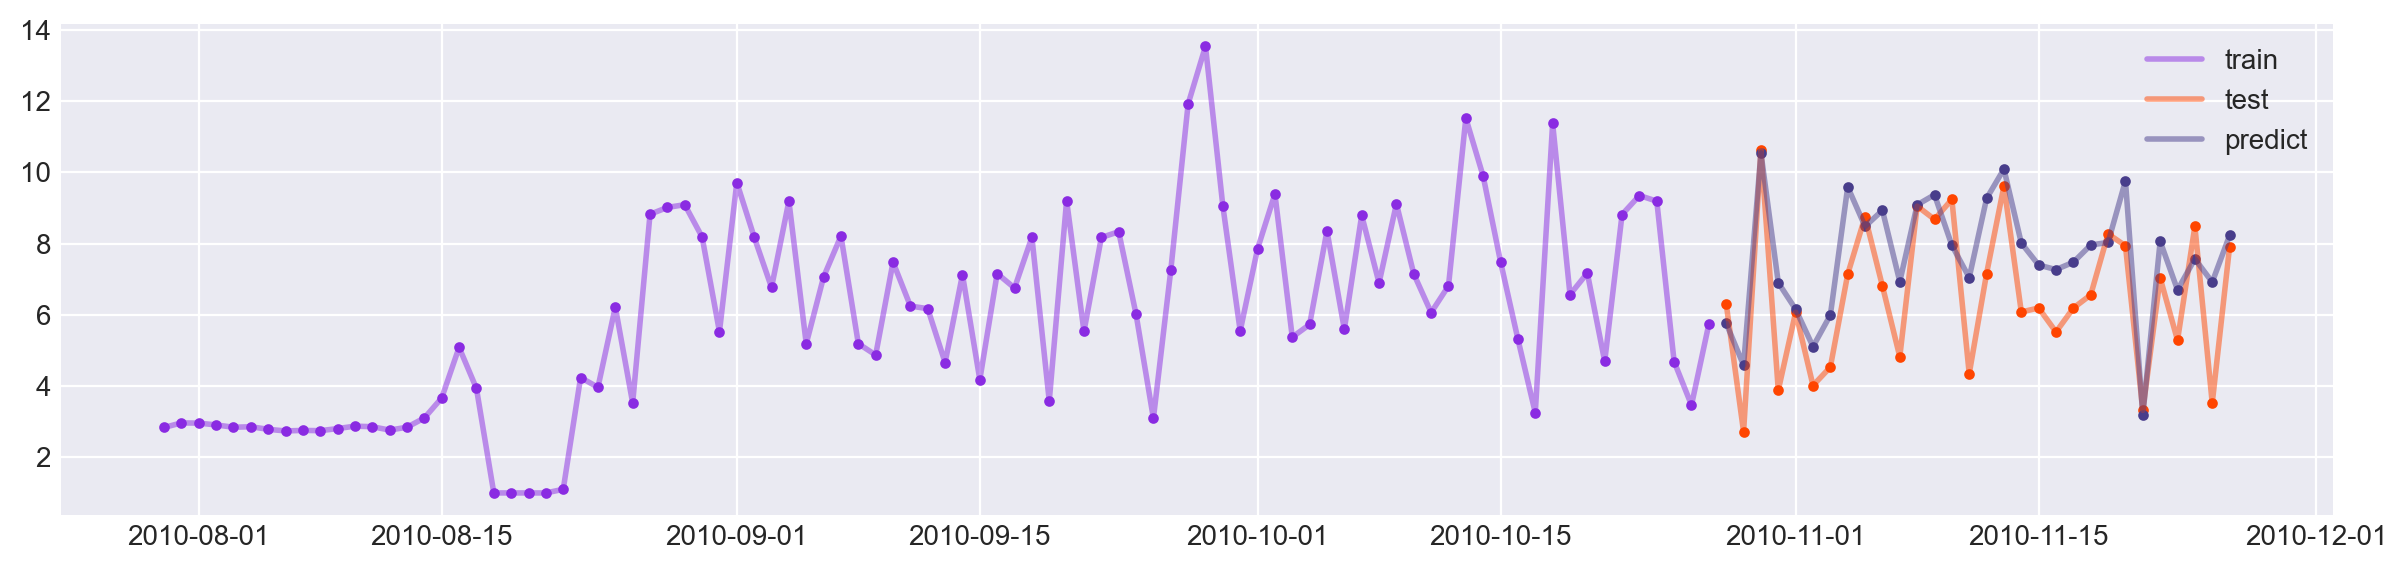

In [27]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
print(grid_search_results["params"])

In [ ]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [ ]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

In [ ]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [ ]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

In [ ]:
resultsDF.T

In [ ]:
plot_metrics(resultsDF)

### Saving results

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Electricity"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Electricity"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Electricity"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)